In [1]:
#Load Libraries
import numpy as np            
import pandas as pd           
import matplotlib.pyplot as plt  
import scipy                  
import filterpy

%matplotlib inline

In [2]:
## Define Functions

In [35]:
import pandas as pd

def read_data():
    accel_data = pd.read_csv('.//2023-11-17-15-11-06//accel-0.csv')
    gps_time_data = pd.read_csv('.//2023-11-17-15-11-06//gps_time.csv')
    gps_visibility_data = pd.read_csv('.//2023-11-17-15-11-06//gps_visibility.csv')
    gps_data = pd.read_csv('.//2023-11-17-15-11-06//ref_gps.csv')
    gyro_data = pd.read_csv('.//2023-11-17-15-11-06//gyro-0.csv')
    mag_data = pd.read_csv('.//2023-11-17-15-11-06//mag-0.csv')
    time_data = pd.read_csv('.//2023-11-17-15-11-06//time.csv')

    # Determine the UTM zone of the first point
    first_point = utm.from_latlon(gps_data.iloc[0]['ref_gps_lat (deg)'], gps_data.iloc[0]['ref_gps_lon (deg)'])
    target_zone_number = first_point[2]
    target_zone_letter = first_point[3]

    # Convert all GPS data to the target UTM zone
    utm_coords = gps_data.apply(
        lambda row: utm.from_latlon(
            row['ref_gps_lat (deg)'],
            row['ref_gps_lon (deg)'],
            force_zone_number=target_zone_number,
            force_zone_letter=target_zone_letter
        ),
        axis=1
    )
    utm_df = pd.DataFrame(
        utm_coords.tolist(),
        columns=['east', 'north', 'zone_number', 'zone_letter']
    )
    
    # Set the first UTM coordinate as the origin
    origin_x, origin_y = utm_df.iloc[0]['east'], utm_df.iloc[0]['north']
    
    # Subtract origin to convert UTM coordinates to position-based data
    gps_data['pos_x'] = utm_df['east'] - origin_x
    gps_data['pos_y'] = utm_df['north'] - origin_y

    
    return accel_data, gps_time_data, gps_visibility_data, gps_data, gyro_data, mag_data, time_data

In [5]:
#Calculate Orientation

def calculate_orientation(a_x, a_y, a_z, previous_pitch, previous_roll):
    
    alpha = 0.9999
    
    theta_z = np.arctan2(a_y, a_z)
    theta_x = np.arctan2(a_x, np.sqrt(a_y**2 + a_z**2))
    pitch = (previous_pitch * alpha) + (theta_x * (1 - alpha))
    roll = (previous_roll * alpha) + (theta_z * (1 - alpha))
    
    return pitch, roll

In [6]:
#Calculate Velocity

def calculate_velocity(a_x, a_y, a_z, previous_velocity_x, previous_velocity_y, previous_velocity_z, delta_t):
    
    velocity_x = previous_velocity_x + a_x * delta_t
    velocity_y = previous_velocity_y + a_y * delta_t
    velocity_z = previous_velocity_z + a_z * delta_t
    
    return velocity_x, velocity_y, velocity_z

In [7]:
#Calculate Position

def calculate_position(previous_position_x, previous_position_y, velocity_x, velocity_y, delta_t):
    
    position_x = previous_position_x + velocity_x * delta_t
    position_y = previous_position_y + velocity_y * delta_t

    return position_x, position_y

In [36]:
# Create Rotation Matrix

def create_rotation_matrix(yaw):

    c, s = np.cos(yaw), np.sin(yaw)
    R = np.array([[-c, -s], [-s, c]])  
    
    return R

In [9]:
from pykalman import KalmanFilter
import numpy as np

def run_kalman_filter(data_in, dt, var):
    # Initialize Kalman Filter parameters
    F = np.array([[1, dt, 0.5 * dt**2], [0, 1, dt], [0, 0, 1]])
    H = np.array([0, 0, 1])
    Q = np.array([[0.2, 0, 0], [0, 0.1, 0], [0, 0, 10e-4]])
    R = np.array([[var]])
    X0 = np.array([0, 0, data_in[0]])
    P0 = np.array([[0, 0, 0], [0, 0, 0], [0, 0, var]])

    # Define the Kalman Filter
    kf = KalmanFilter(transition_matrices=F, observation_matrices=H, transition_covariance=Q, 
                      observation_covariance=R, initial_state_mean=X0, initial_state_covariance=P0)

    # Iterative estimation for each new measurement
    filtered_state_means = np.zeros((len(data_in), 3))
    for t in range(len(data_in)):
        if t == 0:
            filtered_state_means[t] = X0
        else:
            filtered_state_means[t], _ = kf.filter_update(
                filtered_state_means[t-1],
                P0,
                observation=data_in[t]
            )

    return filtered_state_means[:, 2]


In [10]:
def run_kalman_filter_with_transformation(accel_array, mag_data, dt, var):
    # Initialize arrays for filtered acceleration data
    filtered_accel_ned = np.zeros_like(accel_array)

    # Apply Kalman filter to each axis
    for i in range(3):  # For x, y, and z axes
        filtered_axis_data = run_kalman_filter(accel_array[:, i], dt, var)
        filtered_accel_ned[:, i] = filtered_axis_data

    # Transform acceleration data to NED frame
    for i in range(len(filtered_accel_ned)):
        yaw = calculate_yaw(mag_data['mag_x (uT)'].iloc[i], mag_data['mag_y (uT)'].iloc[i])
        R = create_rotation_matrix(yaw)

        # Apply rotation matrix to x and y components
        accel_body = filtered_accel_ned[i, :2]
        accel_ned = R @ accel_body
        filtered_accel_ned[i, :2] = accel_ned

    return filtered_accel_ned

In [37]:
# Calculate Yaw

def calculate_yaw(mag_x, mag_y):
    
    yaw = np.arctan2(mag_y, mag_x)
    
    return yaw

In [53]:
def calculate_position_with_gps_update(filtered_accel_ned, gps_data, gps_time, delta_t):
    # Initialize variables
    prev_pos_x, prev_pos_y, prev_vel_x, prev_vel_y, prev_vel_z = 0, 0, 0, 0, 0

    positions_x, positions_y = [], []

    midpoint = len(filtered_accel_ned) // 2
    midpoint_gps = len(gps_data) // 2
    R = np.array([[0,1],
                 [-1,0]])
    R_gps = np.linalg.inv(R)

    for i in range(len(filtered_accel_ned)):
        # Calculate orientation (implement this function as needed)
        #pitch, roll = calculate_orientation(filtered_accel_ned[i])

        # Calculate velocity
        velocity_x = prev_vel_x + filtered_accel_ned[i, 0] * delta_t
        velocity_y = prev_vel_y + filtered_accel_ned[i, 1] * delta_t
        velocity_z = prev_vel_z + filtered_accel_ned[i, 2] * delta_t

        # Calculate position
        pos_x = prev_pos_x + velocity_x * delta_t
        pos_y = prev_pos_y + velocity_y * delta_t

        # Update previous values
        prev_pos_x, prev_pos_y = pos_x, pos_y
        prev_vel_x, prev_vel_y, prev_vel_z = velocity_x, velocity_y, velocity_z

        # Store positions
        positions_x.append(pos_x)
        positions_y.append(pos_y)

    # Check if GPS update is available
        if i == midpoint:
            pos_x_gps = gps_data['pos_x'].iloc[midpoint_gps]
            pos_y_gps = gps_data['pos_y'].iloc[midpoint_gps]
            pos_x_gps, pos_y_gps = R_gps @ np.array([pos_x_gps, pos_y_gps])

            # Update the positions with the GPS data
            prev_pos_x, prev_pos_y = pos_x_gps, pos_y_gps

    # Convert positions to numpy arrays
    positions_x = np.array(positions_x)
    positions_y = np.array(positions_y)
    positions = np.vstack((positions_x, positions_y))
    positions_x, positions_y = R @ positions

    return positions_x, positions_y

In [151]:
# Add f_gps
def calculate_position_with_gps_update(filtered_accel_ned, gps_data, imu_time, delta_t, f_gps, f_dvl):
    total_samples = len(filtered_accel_ned)
    gps_update_interval = int(total_samples * (f_gps / 100)) 
    dvl_update_interval = int(total_samples * (f_dvl / 100))
    
    # Initialize variables
    prev_pos_x, prev_pos_y, prev_vel_x, prev_vel_y, prev_vel_z = 0, 0, 0, 0, 0
    positions_x, positions_y = [], []
    R = np.array([[0, 1], [-1, 0]])  # Rotation matrix
    R_gps = np.linalg.inv(R)  # Inverse rotation for GPS coordinates

    for i in range(total_samples):
        # Calculate velocity
        velocity_x = prev_vel_x + filtered_accel_ned[i, 0] * delta_t
        velocity_y = prev_vel_y + filtered_accel_ned[i, 1] * delta_t
        velocity_z = prev_vel_z + filtered_accel_ned[i, 2] * delta_t
        
        # Calculate position
        pos_x = prev_pos_x + velocity_x * delta_t
        pos_y = prev_pos_y + velocity_y * delta_t
        
        # Update previous values
        prev_pos_x, prev_pos_y = pos_x, pos_y
        prev_vel_x, prev_vel_y, prev_vel_z = velocity_x, velocity_y, velocity_z
        
        # Store positions
        positions_x.append(pos_x)
        positions_y.append(pos_y)

        # Check if a GPS update is available based on the GPS update frequency
        if i != 0 and i % gps_update_interval == 0:
            # Map the IMU index to the GPS data index
            gps_index = int((i / total_samples) * len(gps_data))
            gps_index = min(gps_index, len(gps_data) - 1)  # Ensure the index doesn't go out of bounds

            # Get GPS update
            pos_x_gps = gps_data['pos_x'].iloc[gps_index]
            pos_y_gps = gps_data['pos_y'].iloc[gps_index]
            pos_x_gps, pos_y_gps = R_gps @ np.array([pos_x_gps, pos_y_gps])

            # Update the positions with the GPS data
            prev_pos_x, prev_pos_y = pos_x_gps, pos_y_gps

        if i != 0 and i % dvl_update_interval == 0:
            # Map the IMU index to the GPS data index
            dvl_index = int((i / total_samples) * len(gps_data))
            dvl_index = min(dvl_index, len(gps_data) - 1)  # Ensure the index doesn't go out of bounds

            # Get GPS update
            dvl_x_gps = gps_data['ref_gps_vE (m/s)'].iloc[dvl_index]
            dvl_y_gps = gps_data['ref_gps_vN (m/s)'].iloc[dvl_index]
            dvl_x_gps, dvl_y_gps = R_gps @ np.array([dvl_x_gps, dvl_y_gps])

            # Update the positions with the GPS data
            prev_vel_x, prev_vel_y = dvl_x_gps, dvl_y_gps

    # Convert positions to numpy arrays
    positions_x = np.array(positions_x)
    positions_y = np.array(positions_y)
    positions = np.vstack((positions_x, positions_y))
    positions_x, positions_y = R @ positions

    return positions_x, positions_y



In [57]:
import matplotlib.pyplot as plt
import numpy as np
import utm
#def plot_data(imu_positions_x, imu_positions_y, gps_data, filtered_accel_x, true_accel_x):
    %matplotlib inline
    # Convert GPS coordinates to UTM
    gps_x = gps_data['pos_x']
    gps_y = gps_data['pos_y']

    # Plot GPS and IMU data
    plt.figure(figsize=(12, 8))
    ax = plt.axes(projection='3d')
    plt.plot(gps_x, gps_y, label='GPS Path', linestyle='-', color='black')
    plt.plot(imu_positions_x, imu_positions_y, label='Calculated IMU Position', linestyle='-', color='red')
    plt.xlabel('East (m)')
    plt.ylabel('North (m)')
    plt.title('GPS and IMU Path Comparison')
    plt.legend()
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

    # Calculate and print the average acceleration error
    #acceleration_error = np.abs(filtered_accel_x - true_accel_x)
    #average_error = np.mean(acceleration_error)
    #print(f"Average Acceleration Error: {average_error:.3f} m/s^2")

    #true_positions = np.column_stack((gps_x, gps_y))
    #estimated_positions = np.column_stack((imu_positions_x, imu_positions_y))
    #distance_away = np.mean(true_positions[-1] - estimated_positions[-1])
    #print(f"Final Distance Away from True Position: {distance_away:.3f} m")

In [164]:
def plot_data(imu_positions, gps_data, labels, f_gps, f_dvl):
    %matplotlib inline
    gps_update_descriptors = {
        100: "No GPS Update",
        50: "Midpoint GPS Update",
        25: "Infrequent GPS Updates",
        10: "Frequent GPS Updates",
        5: "Very Frequent GPS Updates",
        1: "Near-Continuous GPS Updates"}

    dvl_update_descriptors = {
        100: "No DVL Update",
        50: "Midpoint DVL Update",
        25: "Infrequent DVL Updates",
        10: "Frequent DVL Updates",
        5: "Very Frequent DVL Updates",
        1: "Near-Continuous DVL Updates"}
        
    gps_description = gps_update_descriptors.get(f_gps, f"Updates Every {f_gps}% of Duration")
    dvl_description = dvl_update_descriptors.get(f_dvl, f"Updates Every {f_gps}% of Duration")
        
    # Convert GPS coordinates to UTM
    gps_x = gps_data['pos_x']
    gps_y = gps_data['pos_y']

    # Plot
    plt.figure(figsize=(16, 12))
    ax = plt.axes(projection='3d')
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.set_zlabel('Z (m)')
    ax.set_title(f'GPS vs. Estimated Position - {gps_description} - {dvl_description}')

    # Plot GPS path
    ax.plot(gps_x, gps_y, label='GPS Path', linestyle='-', color='black')

    # Plot IMU positions for each noise level
    for label, (x, y) in imu_positions.items():
        ax.plot(x, y, label=label)

    plt.legend()
    plt.show()

In [89]:
import numpy as np

def calculate_rmse(imu_positions_x, imu_positions_y, imu_time, gps_data, gps_time):

    matched_imu_x = []
    matched_imu_y = []
    gps_x = gps_data['pos_x']
    gps_y = gps_data['pos_y']

    # Match IMU data to GPS timestamps
    for gps_t in gps_time:
        idx = (np.abs(imu_time - gps_t)).argmin()
        matched_imu_x.append(imu_positions_x[idx])
        matched_imu_y.append(imu_positions_y[idx])

    # Calculate RMSE
    squared_errors = [(x_imu - x_gps) ** 2 + (y_imu - y_gps) ** 2 for x_imu, y_imu, x_gps, y_gps in zip(matched_imu_x, matched_imu_y, gps_x, gps_y)]
    rmse = np.sqrt(np.mean(squared_errors))

    # Calculate cumulative distance and normalize RMSE
    cumulative_distance = np.sum(np.sqrt(np.diff(gps_x)**2 + np.diff(gps_y)**2))
    normalized_rmse = rmse / cumulative_distance if cumulative_distance != 0 else np.nan
    normalized_rmse = normalized_rmse*100

    rmse = round(rmse, 2)
    normalized_rmse = round(normalized_rmse, 2)

    return rmse, normalized_rmse


# Run Code

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import utm
from pykalman import KalmanFilter
%matplotlib widget

In [39]:
accel_data, gps_time_data, gps_visibility_data, gps_data, gyro_data, mag_data, time_data = read_data()
delta_t=0.01

In [145]:
gps_data

ref_gps_lat (deg)  ref_gps_lon (deg)  ref_gps_alt (m)  ref_gps_vN (m/s)  \
0            32.000000         120.000000              0.0          0.000000   
1            32.000000         120.000000              0.0          0.100000   
2            32.000000         120.000000              0.0          0.199989   
3            32.000000         120.000000              0.0          0.299919   
4            32.000001         120.000000              0.0          0.399664   
..                 ...                ...              ...               ...   
790          32.000098         120.000049              0.0          4.000000   
791          32.000102         120.000049              0.0          4.000000   
792          32.000106         120.000049              0.0          4.000000   
793          32.000109         120.000049              0.0          4.000000   
794          32.000113         120.000049              0.0          4.000000   

     ref_gps_vE (m/s)  ref_gps_vD (m/s)     pos_x      pos_y  
0            0.000000               0.0  0.000000   0.000000  
1            0.000275               0.0  0.000131   0.004501  
2            0.002100               0.0  0.000624   0.019001  
3            0.006974               0.0  0.001703   0.043491  
4            0.016395               0.0  0.003739   0.077951  
..                ...               ...       ...        ...  
790         -0.000493               0.0  4.976390  10.787863  
791         -0.000467               0.0  4.987453  11.187946  
792         -0.000443               0.0  4.998519  11.588030  
793         -0.000421               0.0  5.009586  11.988113  
794         -0.000399               0.0  5.020656  12.388196  

[795 rows x 8 columns]

In [ ]:
f_gps_values = [100,50,25,10,5,1]
noise_percentages = [10,50]

for f_gps in f_gps_values:
    
    imu_positions = {}
    rmse_results = pd.DataFrame(columns=["Noise (% amplitude of Acceleration)", " Average RMSE: Distance from path (m)", "Average RMSE: Normalized per distance traveled (%)"])
    
    for noise_percentage in noise_percentages:
        # Calculate noise amplitude as a percentage of the acceleration value
        noise_amplitude_x = noise_percentage / 100 * accel_data['accel_x (m/s^2)']
        noise_amplitude_y = noise_percentage / 100 * accel_data['accel_y (m/s^2)']
        noise_amplitude_z = noise_percentage / 100 * accel_data['accel_z (m/s^2)']
    
        # Generate random noise within the range and add it to the acceleration data
        noisy_accel_x = accel_data['accel_x (m/s^2)'] + np.random.uniform(-noise_amplitude_x, noise_amplitude_x)
        noisy_accel_y = accel_data['accel_y (m/s^2)'] + np.random.uniform(-noise_amplitude_y, noise_amplitude_y)
        noisy_accel_z = accel_data['accel_z (m/s^2)'] + np.random.uniform(-noise_amplitude_z, noise_amplitude_z)
    
        # Combine noisy acceleration into a single numpy array
        noisy_accel = np.column_stack((noisy_accel_x, noisy_accel_y, noisy_accel_z))
    
        # Run Kalman filter and transform acceleration to NED frame
        filtered_accel_ned = run_kalman_filter_with_transformation(noisy_accel, mag_data, delta_t, var=noise_level**2)
    
        # Calculate positions with GPS update
        imu_positions_x, imu_positions_y = calculate_position_with_gps_update(filtered_accel_ned, gps_data, time_data['time (sec)'], delta_t, f_gps)
    
        #Calculate RMSE
        rmse, normalized_rmse = calculate_rmse(imu_positions_x, imu_positions_y, time_data['time (sec)'], gps_data, gps_time_data['gps_time (sec)'])
        
        imu_positions[f"Noise {noise_percentage}%"] = (imu_positions_x, imu_positions_y)
    
        rmse_results.loc[len(rmse_results)] = [f"{noise_percentage}%", rmse, normalized_rmse]
    
    # Plot all data
    plot_data(imu_positions, gps_data, [f"Noise {n}% Acceleration Amplitude" for n in noise_percentages], f_gps)
    print(rmse_results)

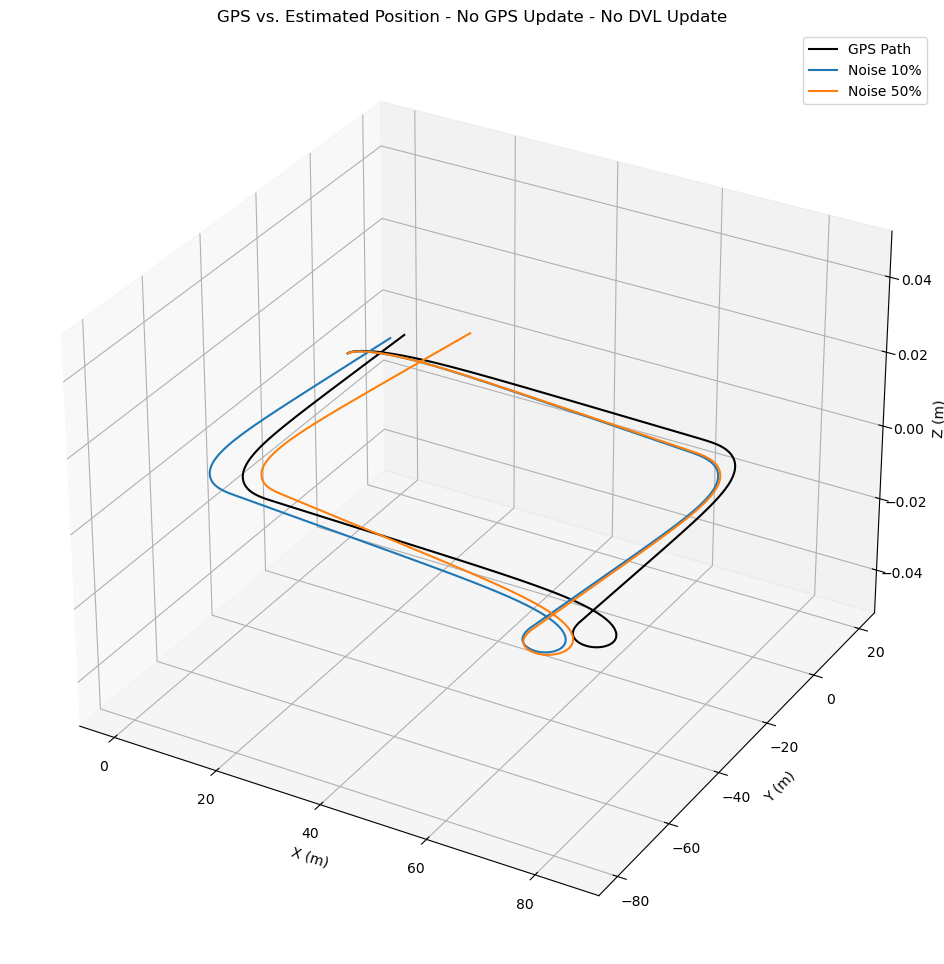

  Noise (% amplitude of Acceleration)   Average RMSE: Distance from path (m)  \
0                                 10%                                   5.92   
1                                 50%                                   6.06   

   Average RMSE: Normalized per distance traveled (%)  
0                                               1.91   
1                                               1.96   


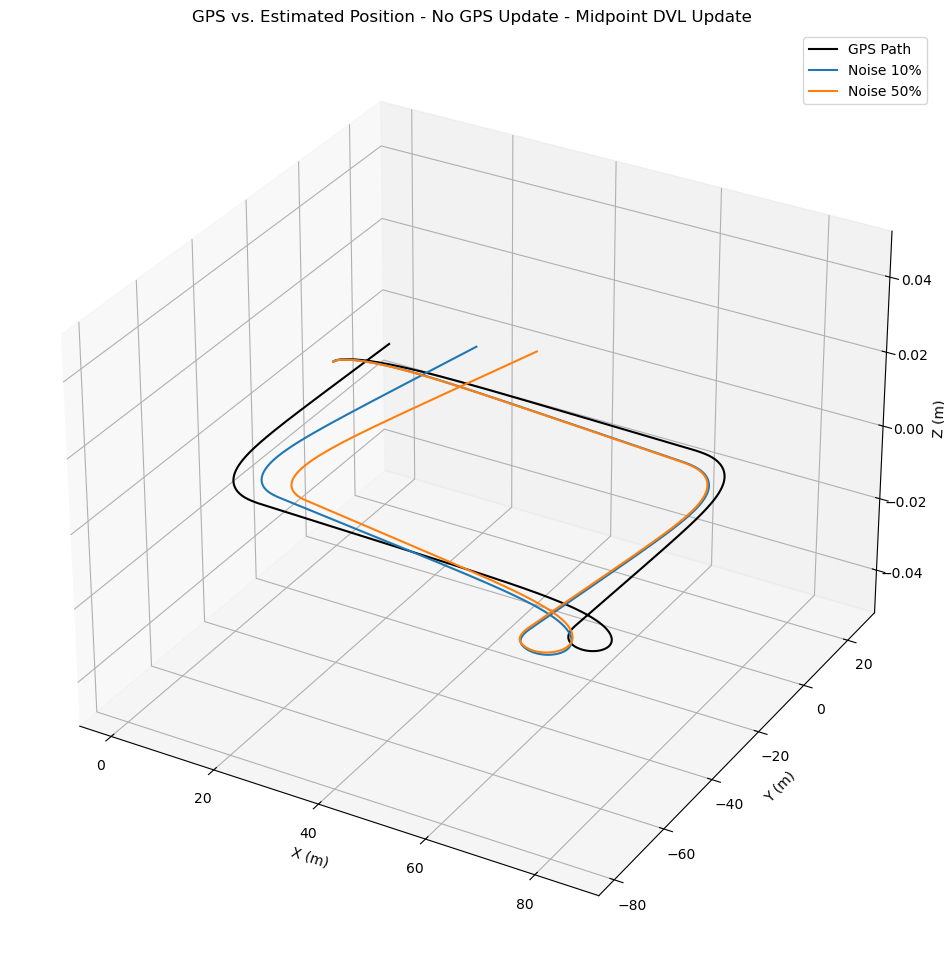

  Noise (% amplitude of Acceleration)   Average RMSE: Distance from path (m)  \
0                                 10%                                   6.70   
1                                 50%                                   9.94   

   Average RMSE: Normalized per distance traveled (%)  
0                                               2.16   
1                                               3.21   


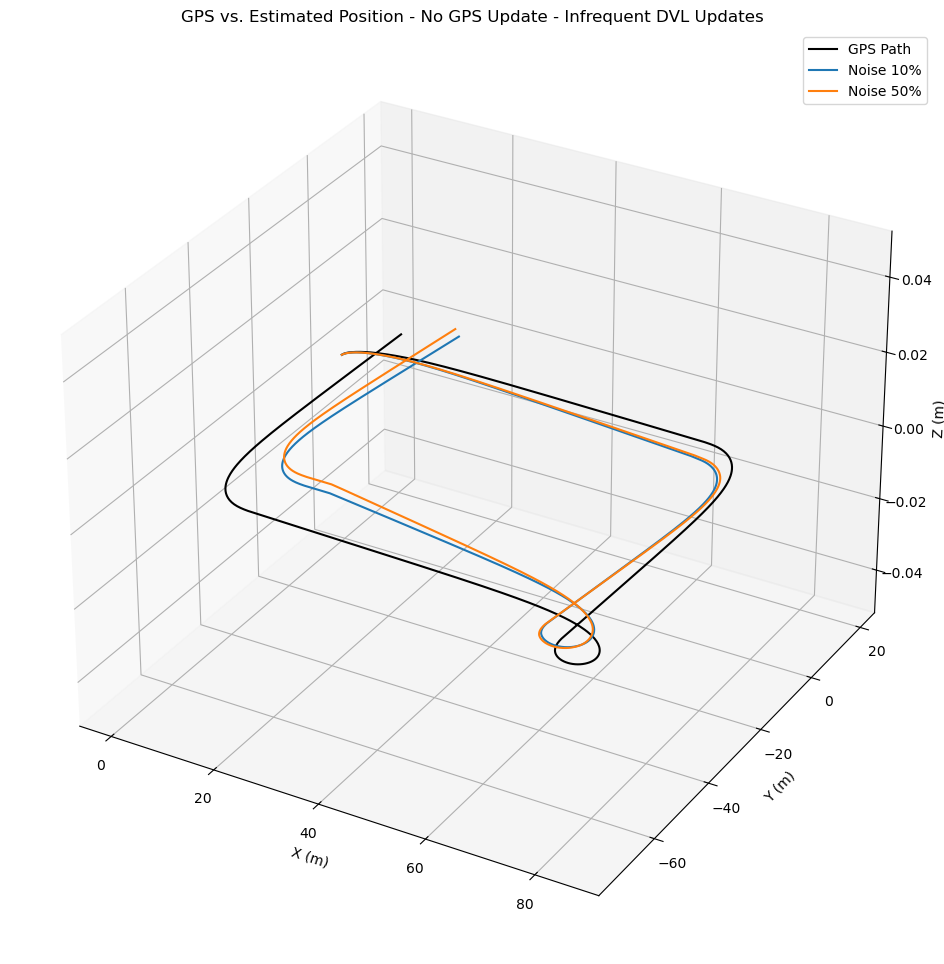

  Noise (% amplitude of Acceleration)   Average RMSE: Distance from path (m)  \
0                                 10%                                   7.54   
1                                 50%                                   8.44   

   Average RMSE: Normalized per distance traveled (%)  
0                                               2.43   
1                                               2.73   


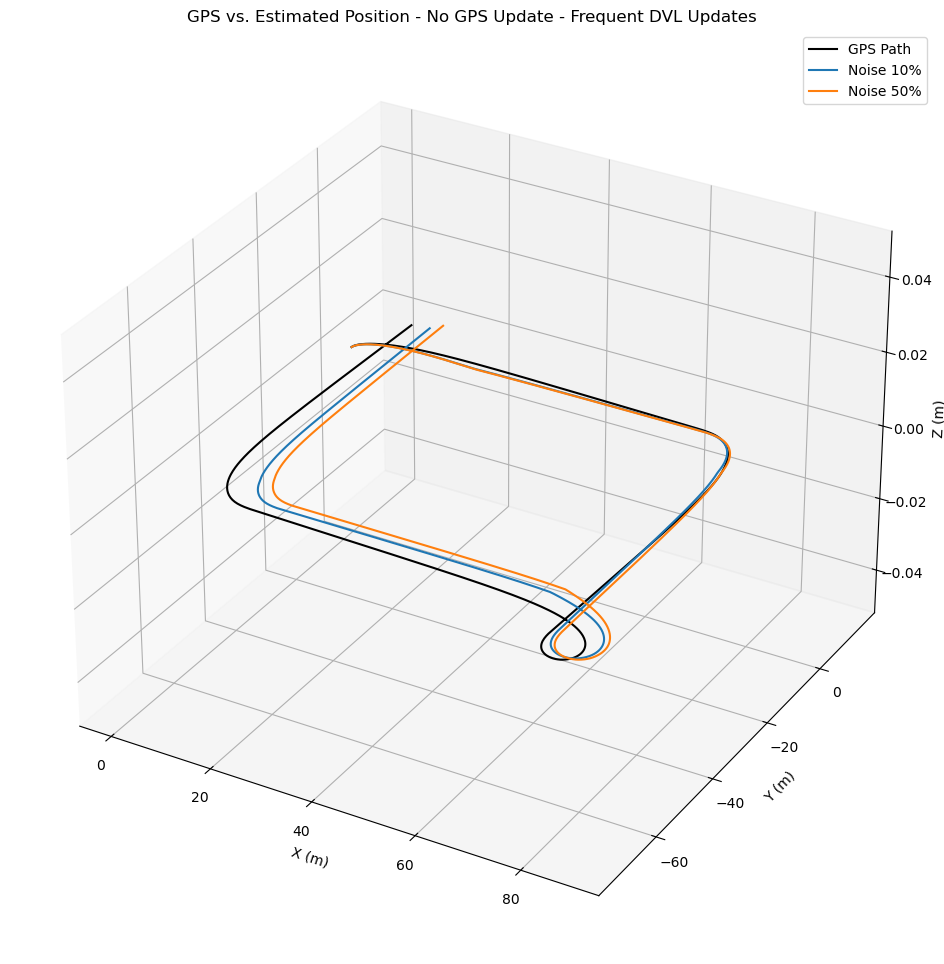

  Noise (% amplitude of Acceleration)   Average RMSE: Distance from path (m)  \
0                                 10%                                   3.48   
1                                 50%                                   5.06   

   Average RMSE: Normalized per distance traveled (%)  
0                                               1.12   
1                                               1.63   


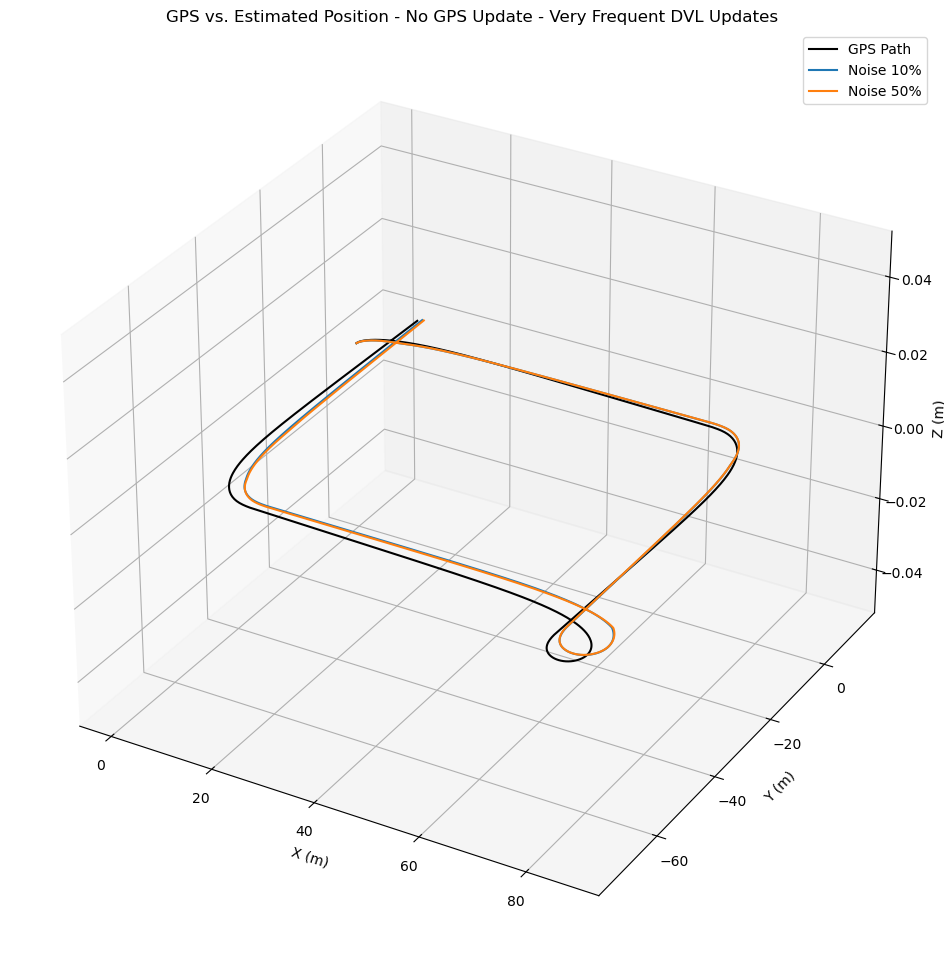

  Noise (% amplitude of Acceleration)   Average RMSE: Distance from path (m)  \
0                                 10%                                   2.43   
1                                 50%                                   2.45   

   Average RMSE: Normalized per distance traveled (%)  
0                                               0.78   
1                                               0.79   


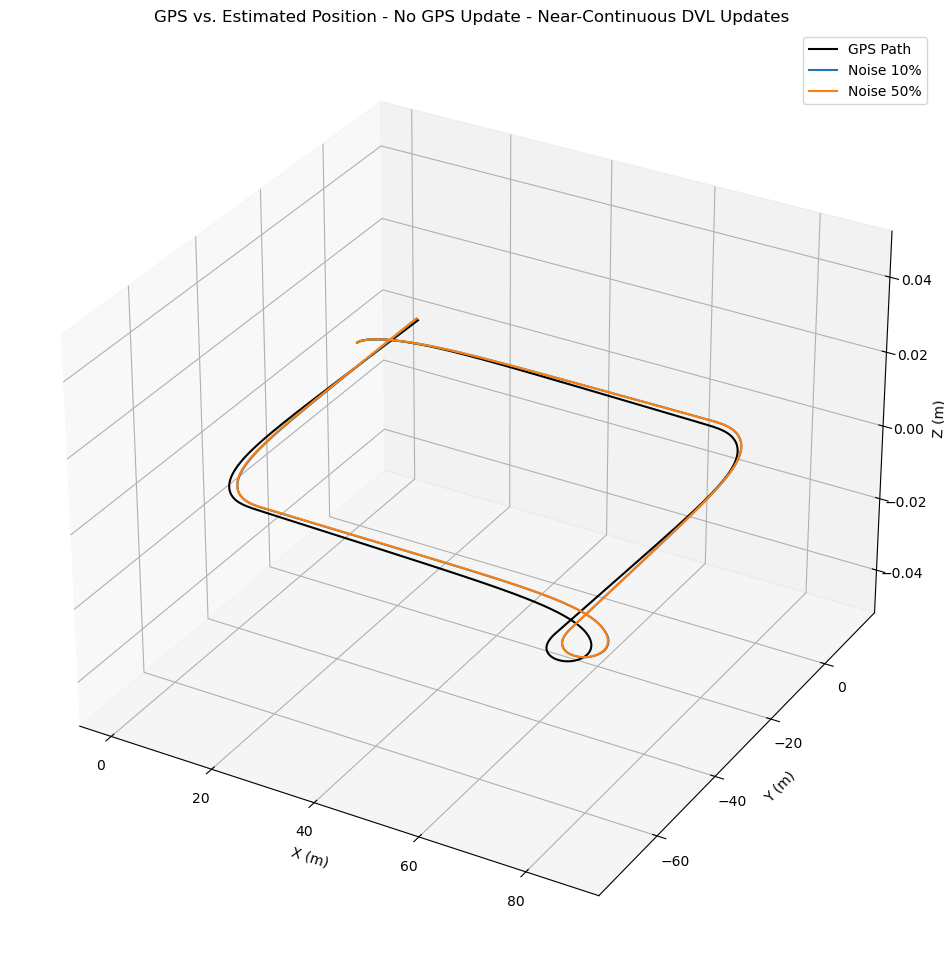

  Noise (% amplitude of Acceleration)   Average RMSE: Distance from path (m)  \
0                                 10%                                   1.85   
1                                 50%                                   1.85   

   Average RMSE: Normalized per distance traveled (%)  
0                                                0.6   
1                                                0.6   


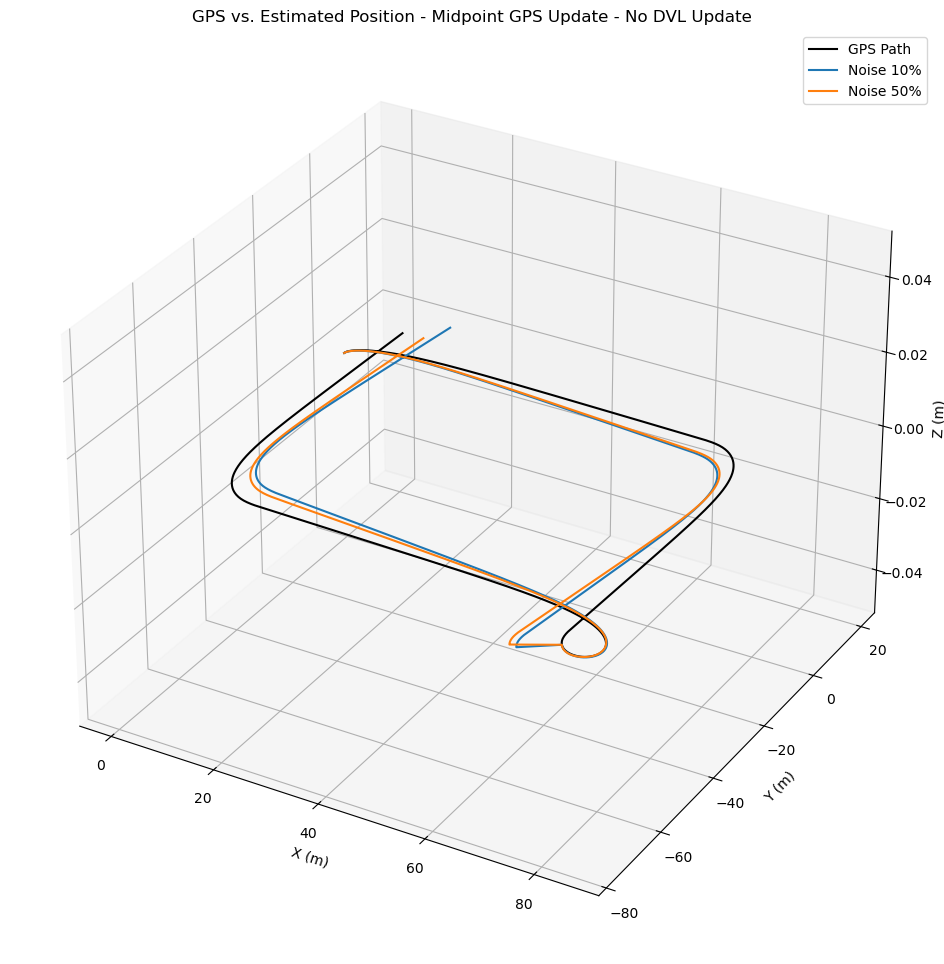

  Noise (% amplitude of Acceleration)   Average RMSE: Distance from path (m)  \
0                                 10%                                   5.23   
1                                 50%                                   4.08   

   Average RMSE: Normalized per distance traveled (%)  
0                                               1.69   
1                                               1.32   


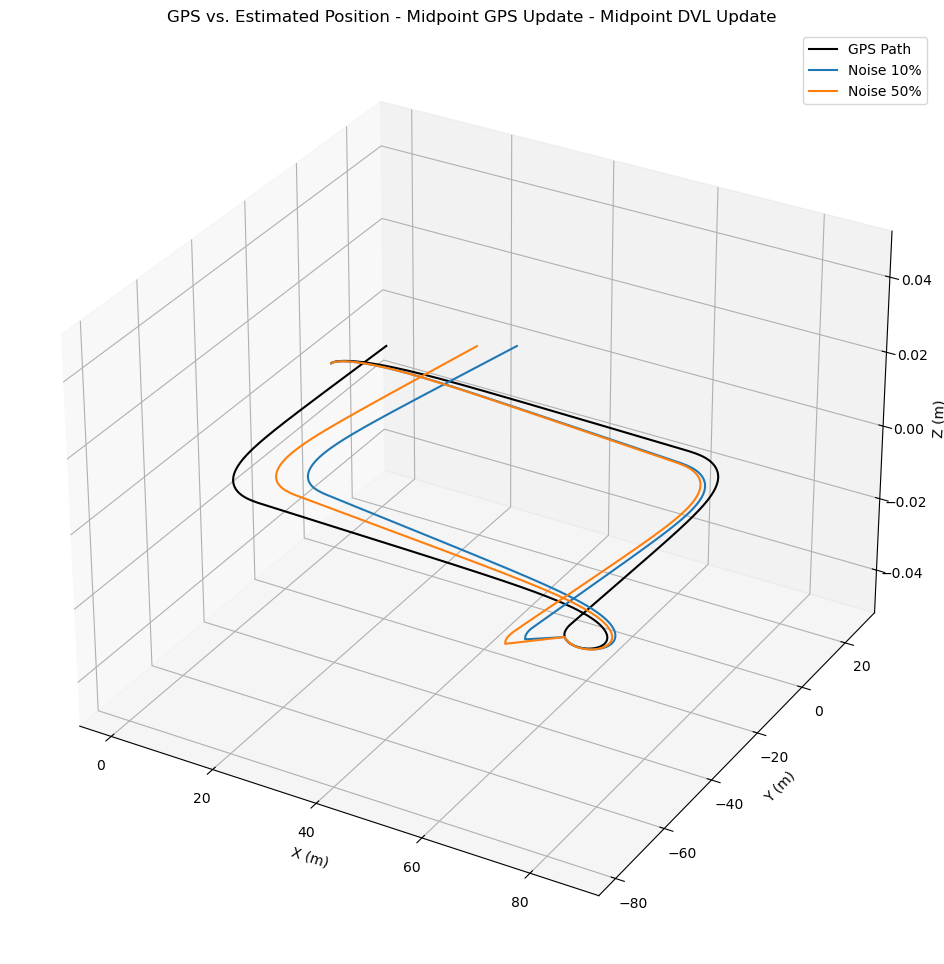

  Noise (% amplitude of Acceleration)   Average RMSE: Distance from path (m)  \
0                                 10%                                  10.35   
1                                 50%                                   7.72   

   Average RMSE: Normalized per distance traveled (%)  
0                                               3.34   
1                                               2.49   


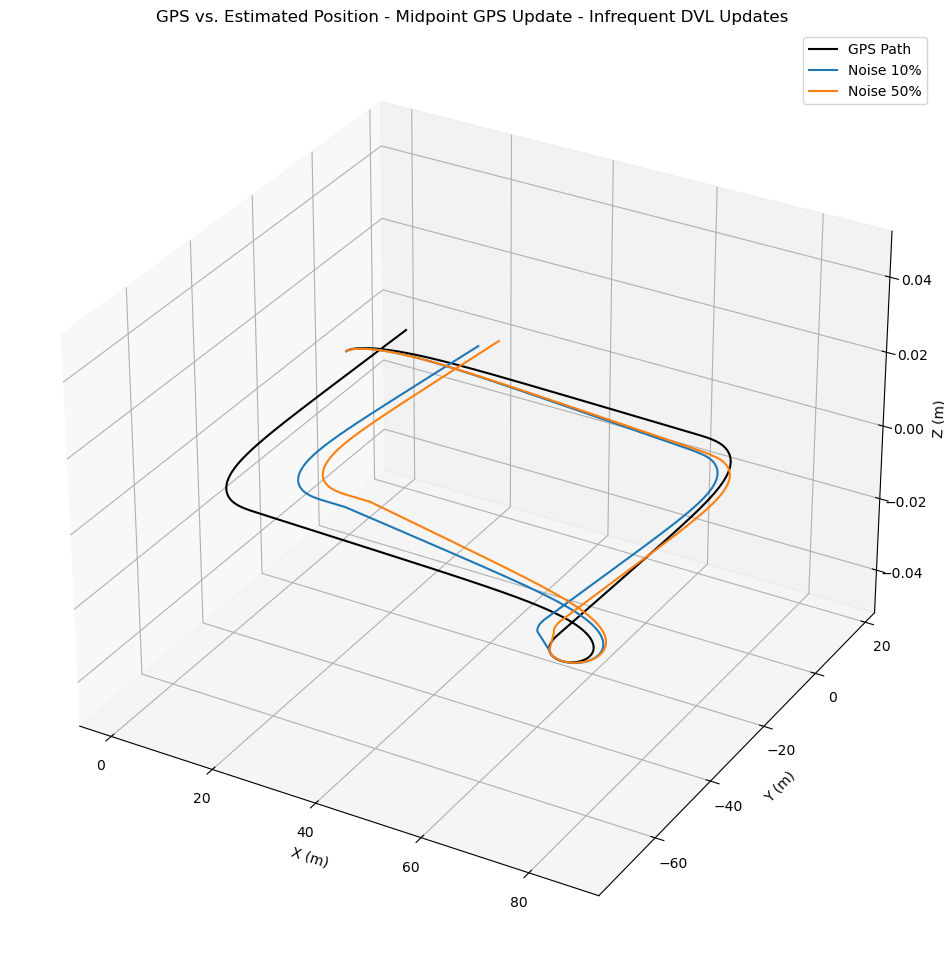

  Noise (% amplitude of Acceleration)   Average RMSE: Distance from path (m)  \
0                                 10%                                   7.71   
1                                 50%                                   9.88   

   Average RMSE: Normalized per distance traveled (%)  
0                                               2.49   
1                                               3.19   


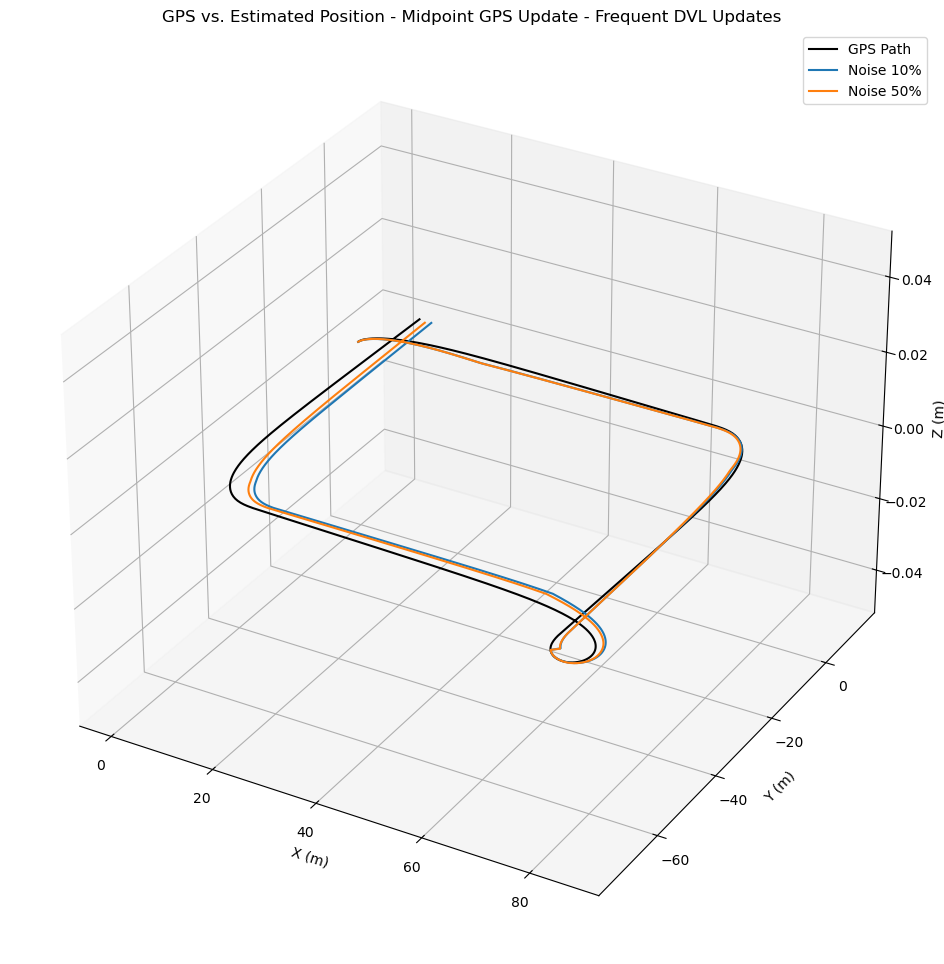

  Noise (% amplitude of Acceleration)   Average RMSE: Distance from path (m)  \
0                                 10%                                   2.71   
1                                 50%                                   2.11   

   Average RMSE: Normalized per distance traveled (%)  
0                                               0.88   
1                                               0.68   


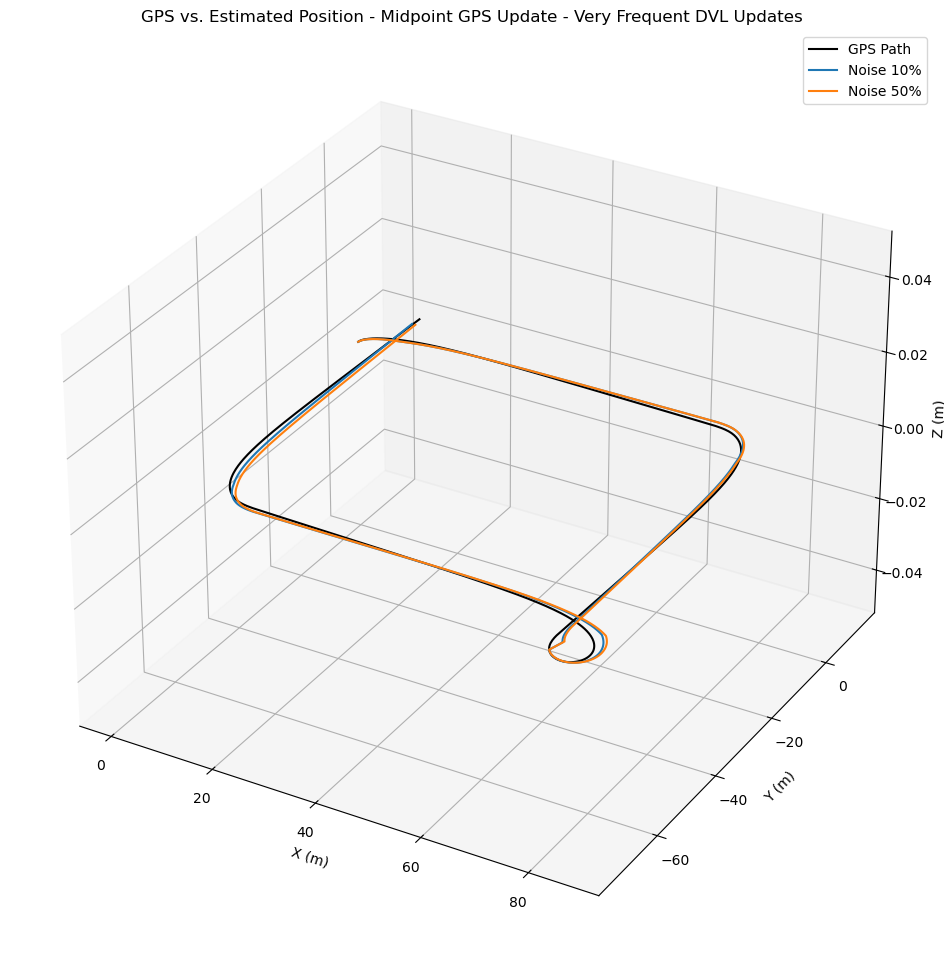

  Noise (% amplitude of Acceleration)   Average RMSE: Distance from path (m)  \
0                                 10%                                   1.86   
1                                 50%                                   2.19   

   Average RMSE: Normalized per distance traveled (%)  
0                                               0.60   
1                                               0.71   


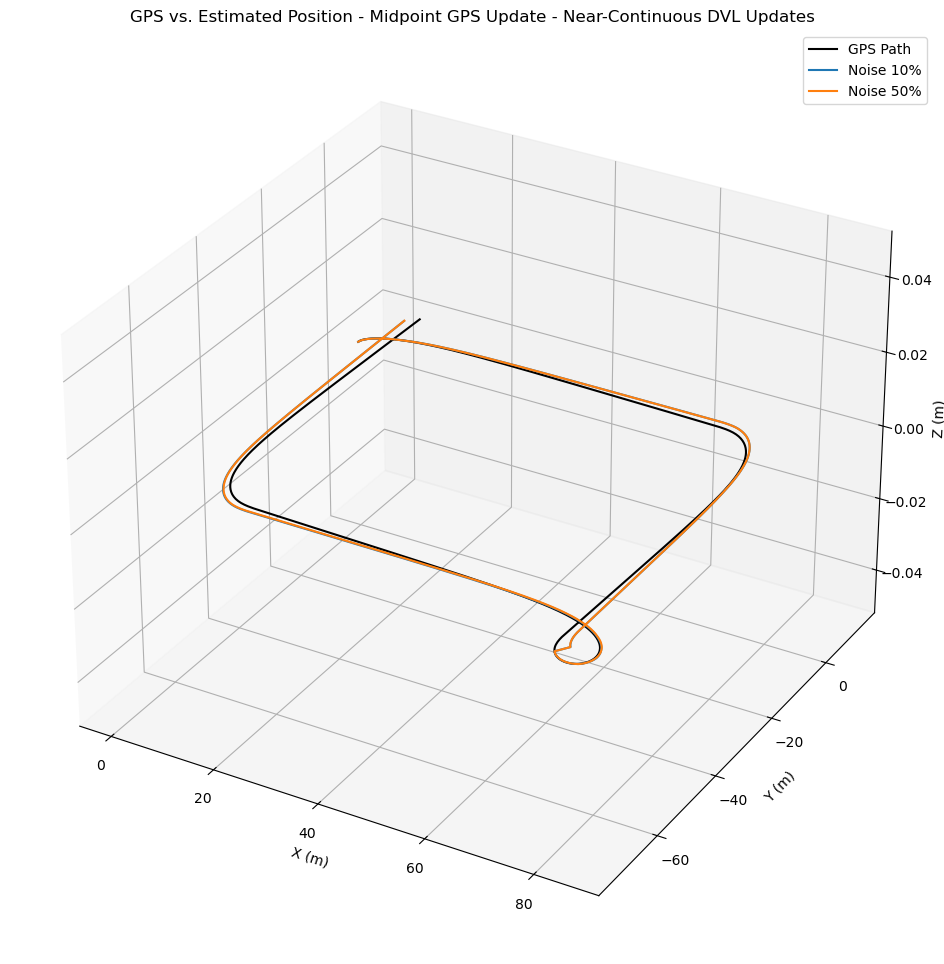

  Noise (% amplitude of Acceleration)   Average RMSE: Distance from path (m)  \
0                                 10%                                   1.71   
1                                 50%                                   1.66   

   Average RMSE: Normalized per distance traveled (%)  
0                                               0.55   
1                                               0.54   


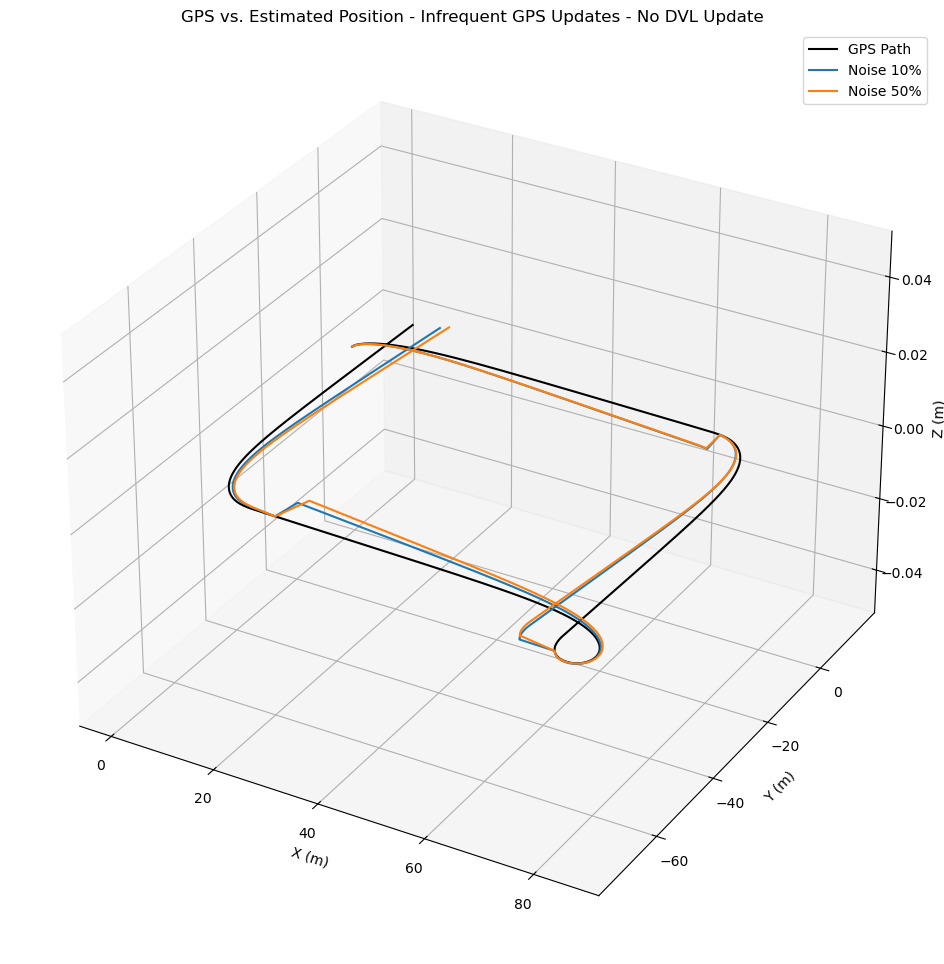

  Noise (% amplitude of Acceleration)   Average RMSE: Distance from path (m)  \
0                                 10%                                   3.16   
1                                 50%                                   3.73   

   Average RMSE: Normalized per distance traveled (%)  
0                                               1.02   
1                                               1.20   


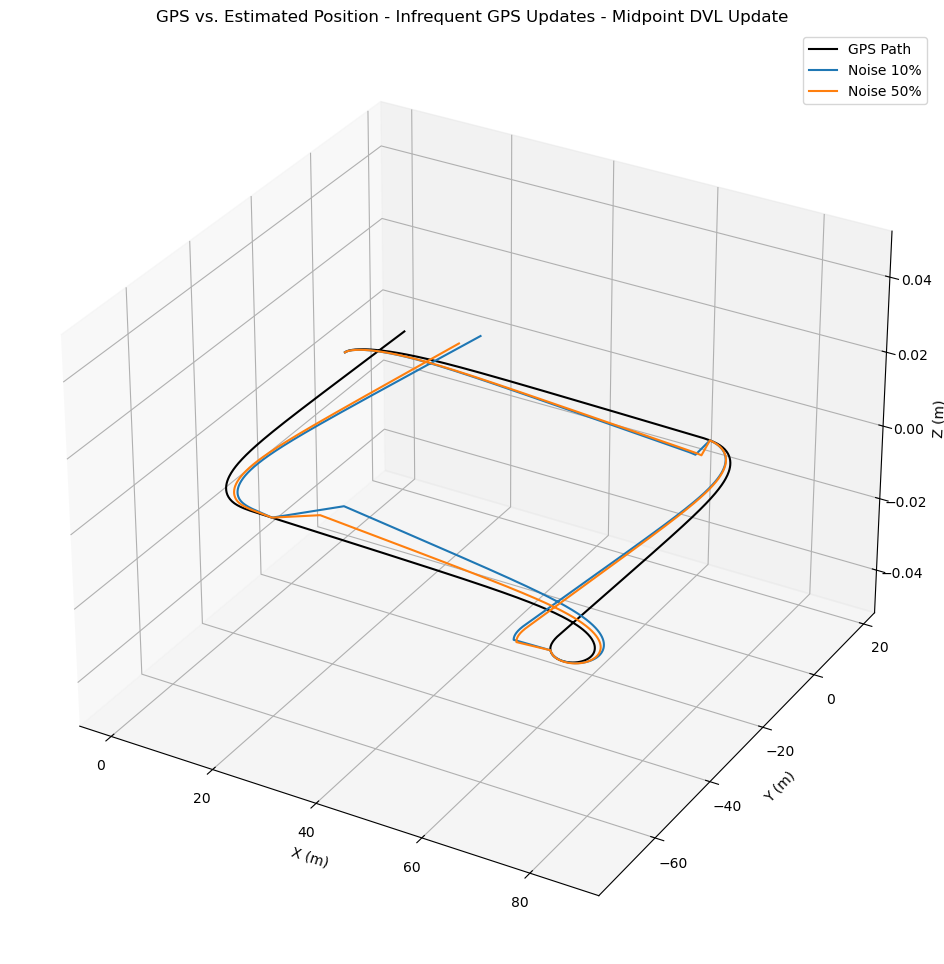

  Noise (% amplitude of Acceleration)   Average RMSE: Distance from path (m)  \
0                                 10%                                   5.82   
1                                 50%                                   4.40   

   Average RMSE: Normalized per distance traveled (%)  
0                                               1.88   
1                                               1.42   


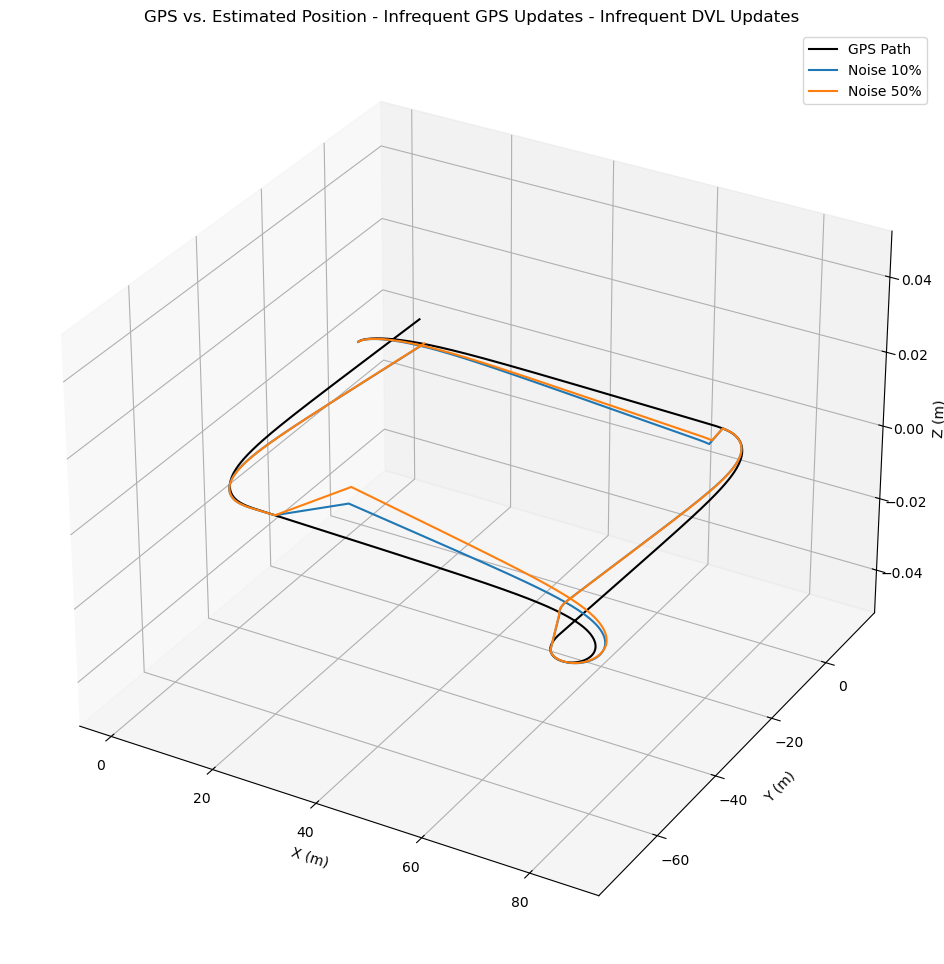

  Noise (% amplitude of Acceleration)   Average RMSE: Distance from path (m)  \
0                                 10%                                   5.54   
1                                 50%                                   5.88   

   Average RMSE: Normalized per distance traveled (%)  
0                                               1.79   
1                                               1.90   


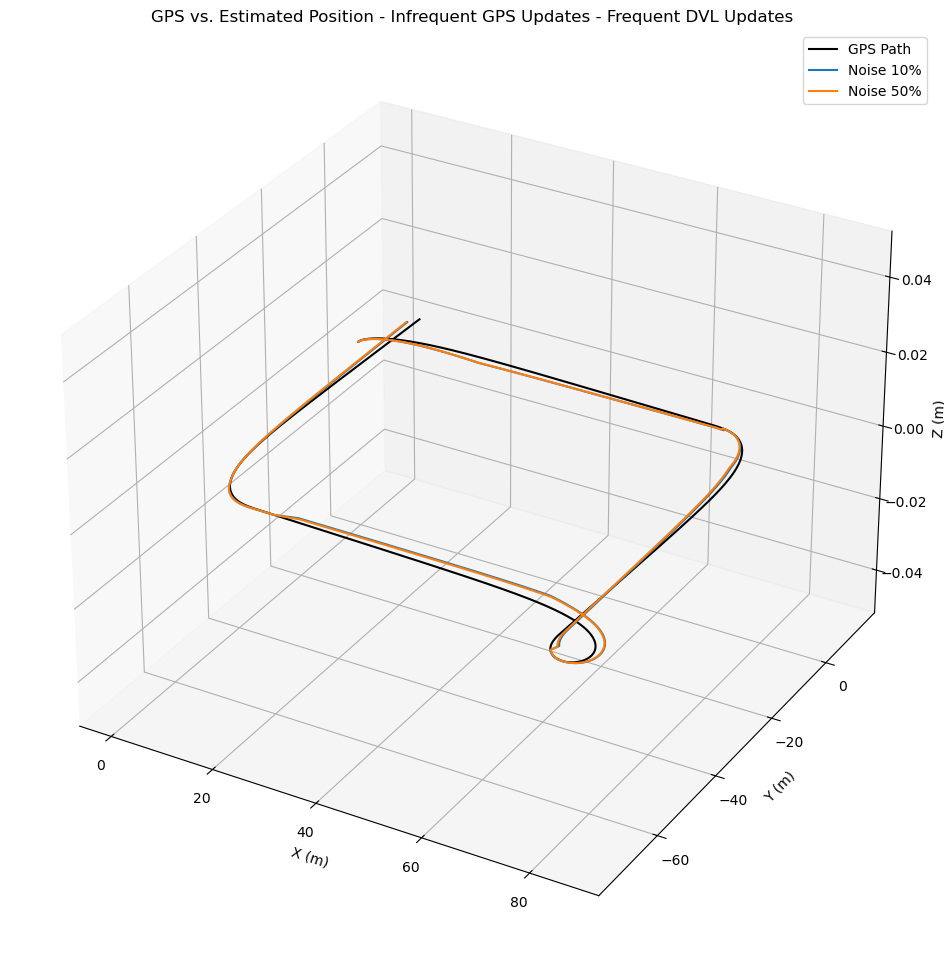

  Noise (% amplitude of Acceleration)   Average RMSE: Distance from path (m)  \
0                                 10%                                   2.17   
1                                 50%                                   2.22   

   Average RMSE: Normalized per distance traveled (%)  
0                                               0.70   
1                                               0.72   


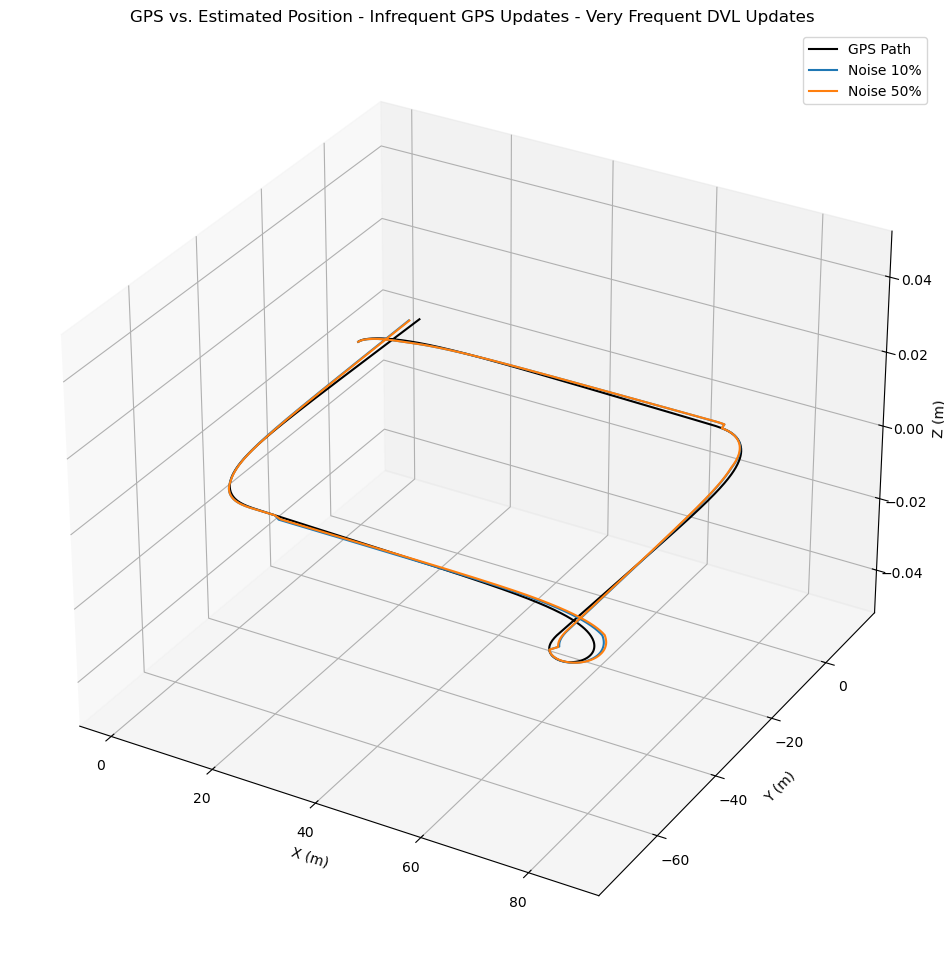

  Noise (% amplitude of Acceleration)   Average RMSE: Distance from path (m)  \
0                                 10%                                   1.24   
1                                 50%                                   1.24   

   Average RMSE: Normalized per distance traveled (%)  
0                                                0.4   
1                                                0.4   


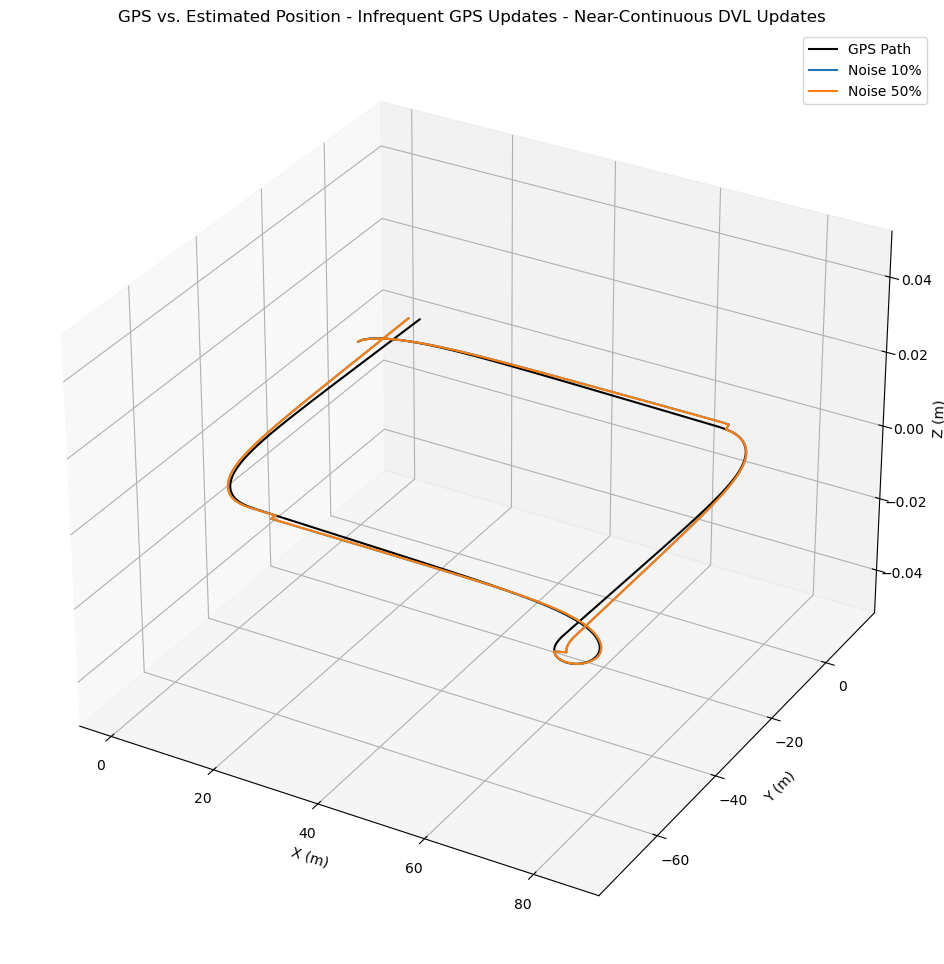

  Noise (% amplitude of Acceleration)   Average RMSE: Distance from path (m)  \
0                                 10%                                   1.00   
1                                 50%                                   0.99   

   Average RMSE: Normalized per distance traveled (%)  
0                                               0.32   
1                                               0.32   


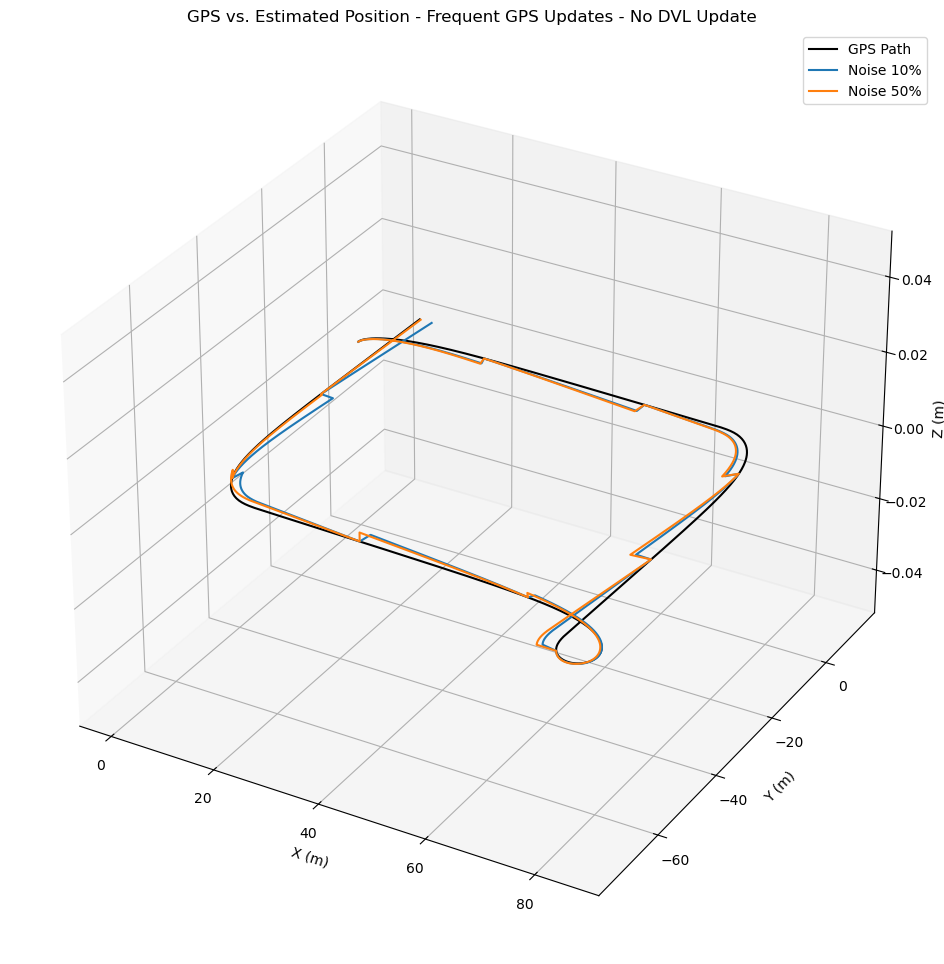

  Noise (% amplitude of Acceleration)   Average RMSE: Distance from path (m)  \
0                                 10%                                   1.41   
1                                 50%                                   1.46   

   Average RMSE: Normalized per distance traveled (%)  
0                                               0.46   
1                                               0.47   


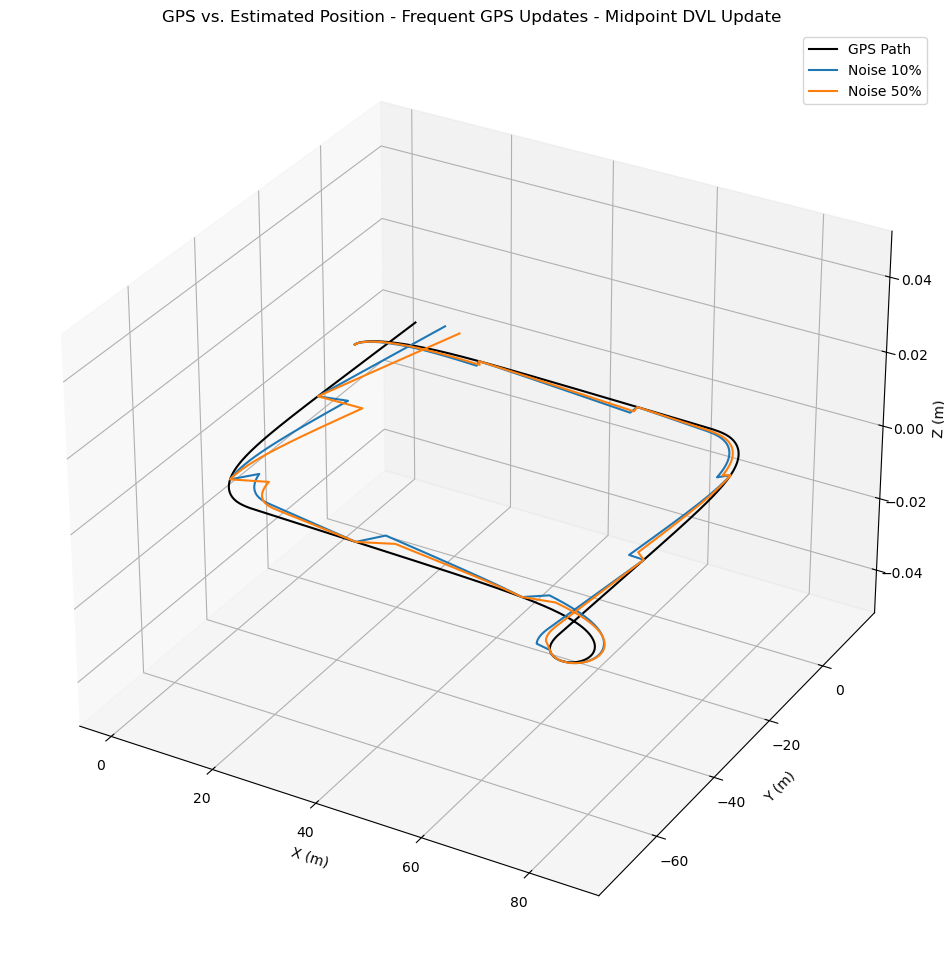

  Noise (% amplitude of Acceleration)   Average RMSE: Distance from path (m)  \
0                                 10%                                   2.32   
1                                 50%                                   3.09   

   Average RMSE: Normalized per distance traveled (%)  
0                                               0.75   
1                                               1.00   


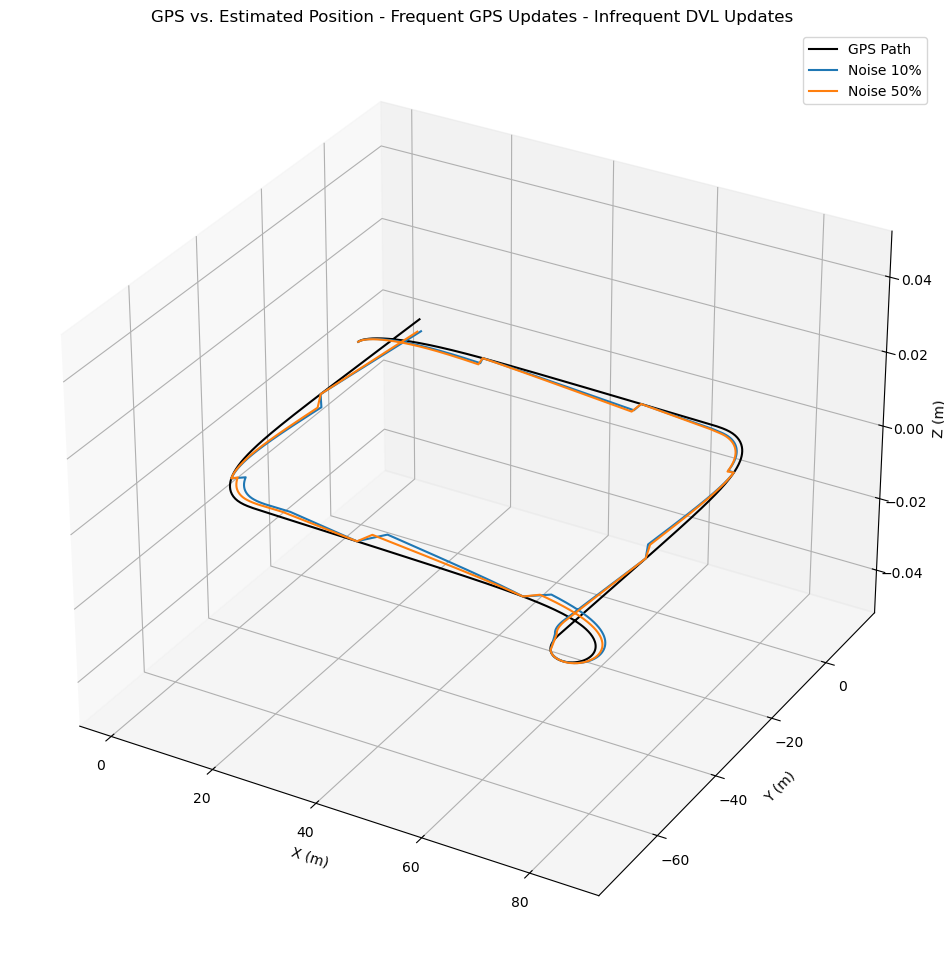

  Noise (% amplitude of Acceleration)   Average RMSE: Distance from path (m)  \
0                                 10%                                   2.28   
1                                 50%                                   2.05   

   Average RMSE: Normalized per distance traveled (%)  
0                                               0.74   
1                                               0.66   


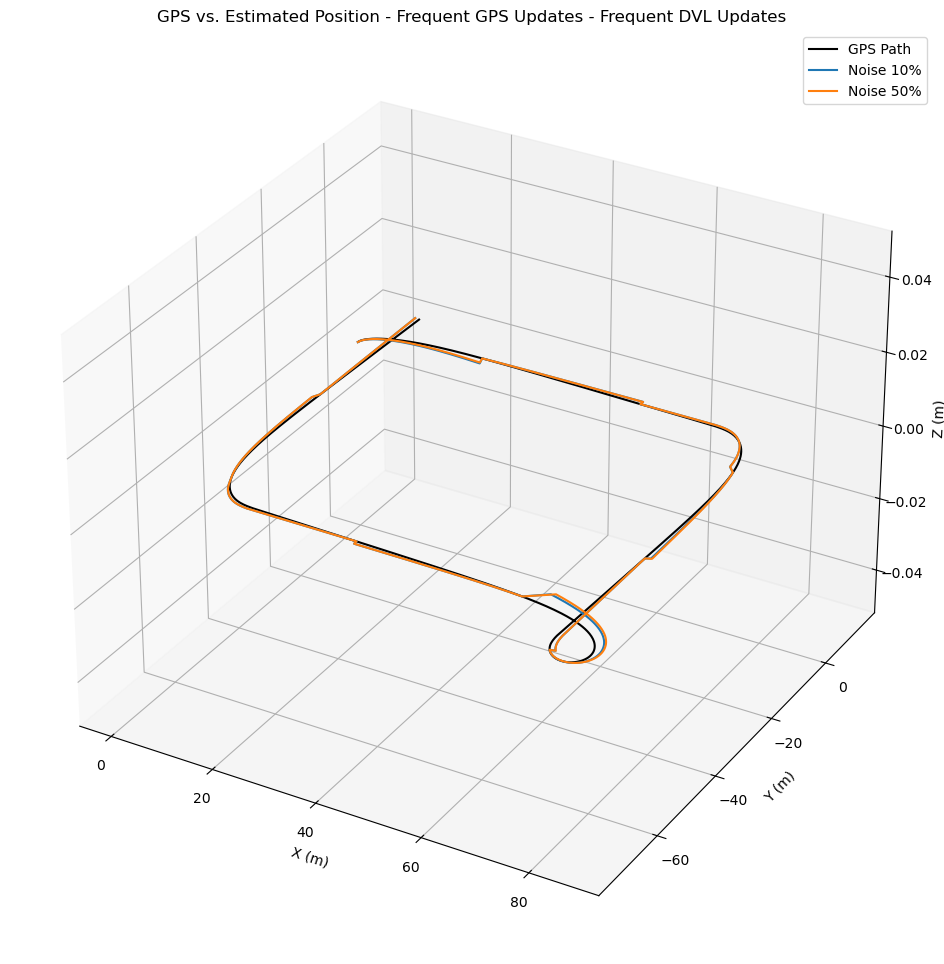

  Noise (% amplitude of Acceleration)   Average RMSE: Distance from path (m)  \
0                                 10%                                   1.04   
1                                 50%                                   1.15   

   Average RMSE: Normalized per distance traveled (%)  
0                                               0.34   
1                                               0.37   


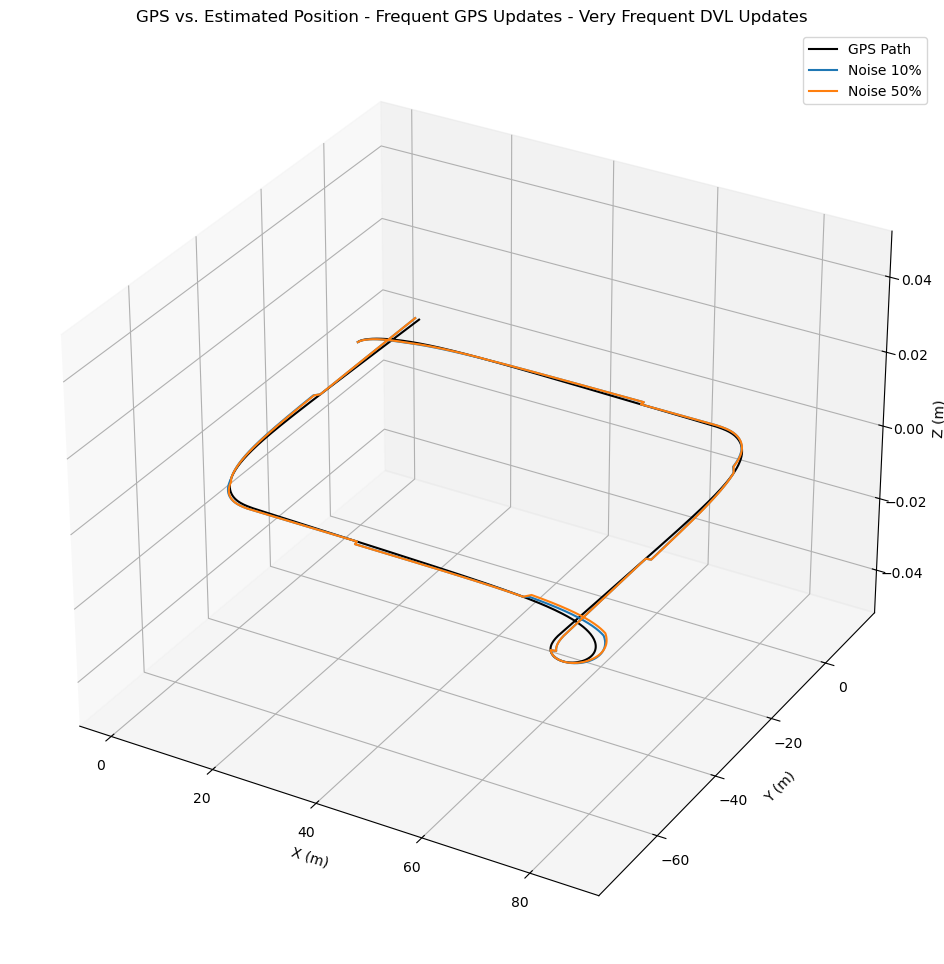

  Noise (% amplitude of Acceleration)   Average RMSE: Distance from path (m)  \
0                                 10%                                   0.73   
1                                 50%                                   0.76   

   Average RMSE: Normalized per distance traveled (%)  
0                                               0.23   
1                                               0.25   


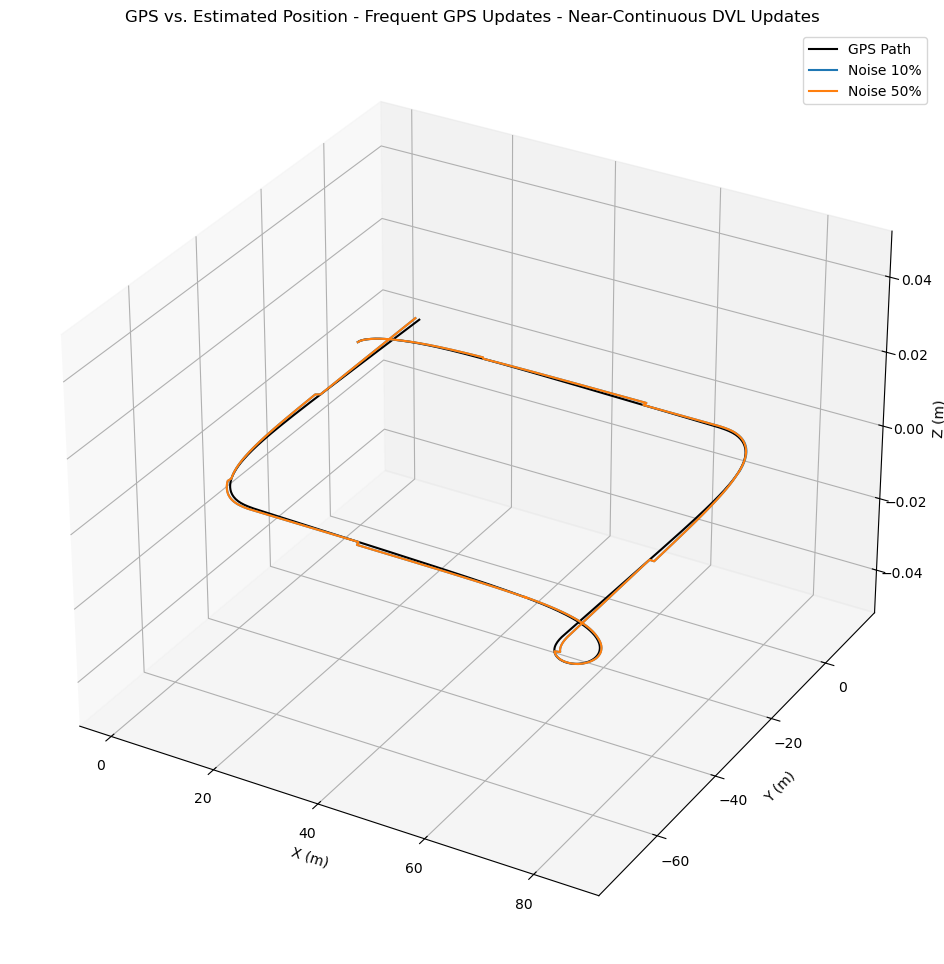

  Noise (% amplitude of Acceleration)   Average RMSE: Distance from path (m)  \
0                                 10%                                   0.51   
1                                 50%                                   0.51   

   Average RMSE: Normalized per distance traveled (%)  
0                                               0.17   
1                                               0.17   


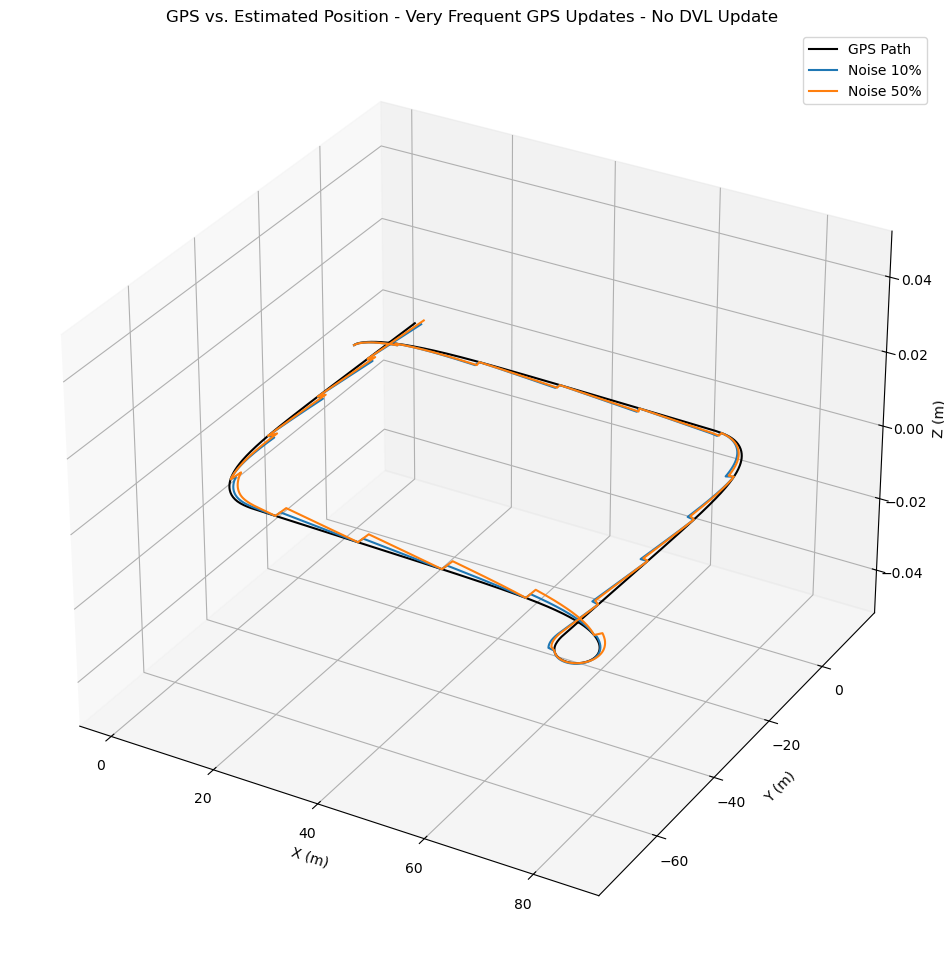

  Noise (% amplitude of Acceleration)   Average RMSE: Distance from path (m)  \
0                                 10%                                   0.74   
1                                 50%                                   1.12   

   Average RMSE: Normalized per distance traveled (%)  
0                                               0.24   
1                                               0.36   


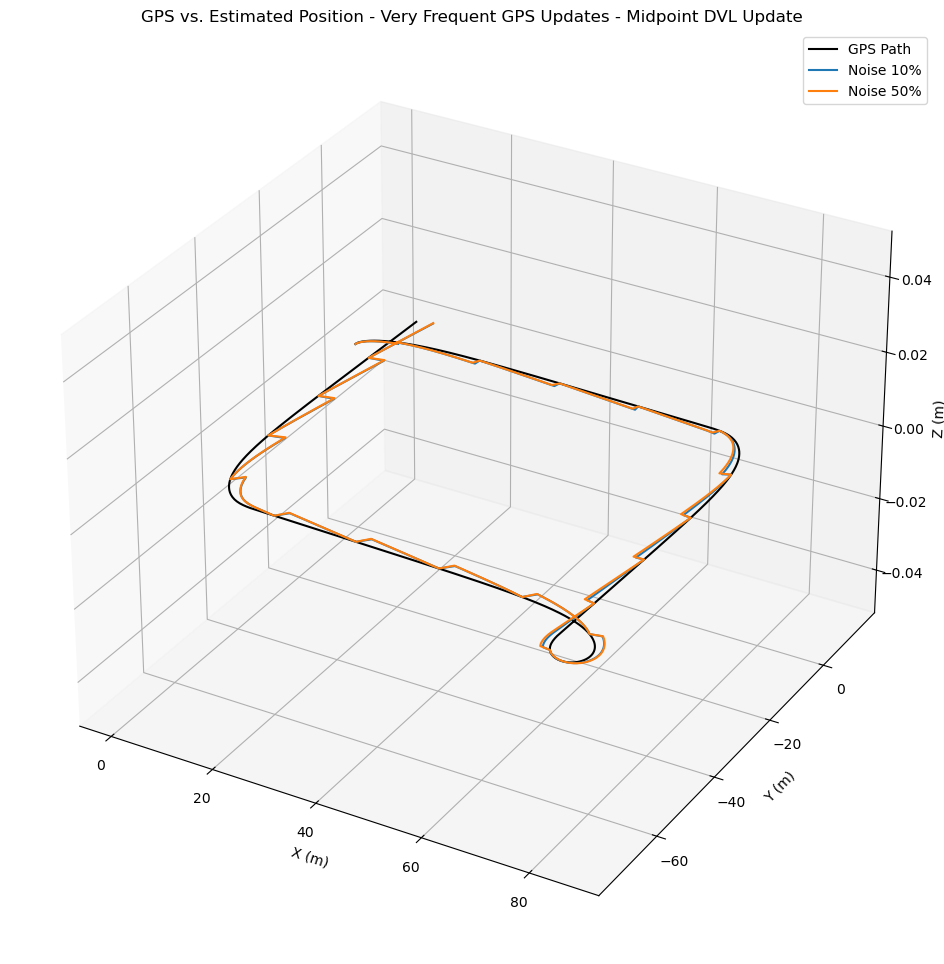

  Noise (% amplitude of Acceleration)   Average RMSE: Distance from path (m)  \
0                                 10%                                   1.25   
1                                 50%                                   1.31   

   Average RMSE: Normalized per distance traveled (%)  
0                                               0.40   
1                                               0.42   


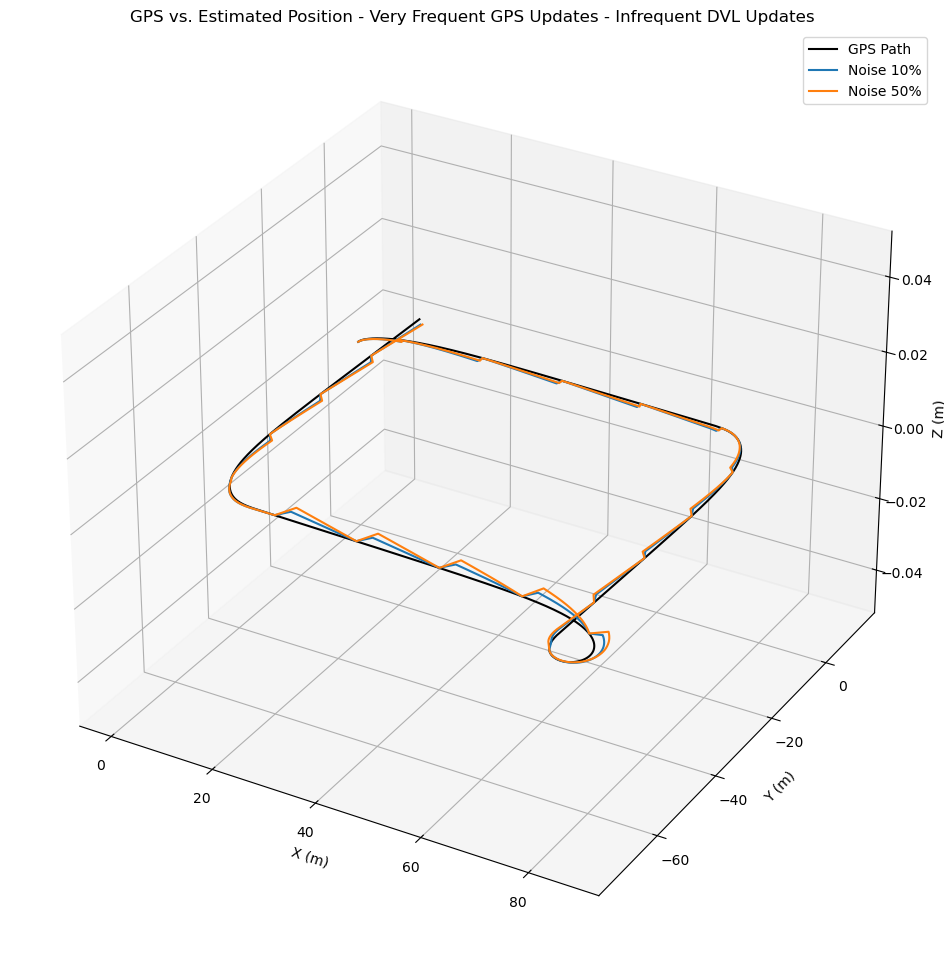

  Noise (% amplitude of Acceleration)   Average RMSE: Distance from path (m)  \
0                                 10%                                   1.21   
1                                 50%                                   1.44   

   Average RMSE: Normalized per distance traveled (%)  
0                                               0.39   
1                                               0.47   


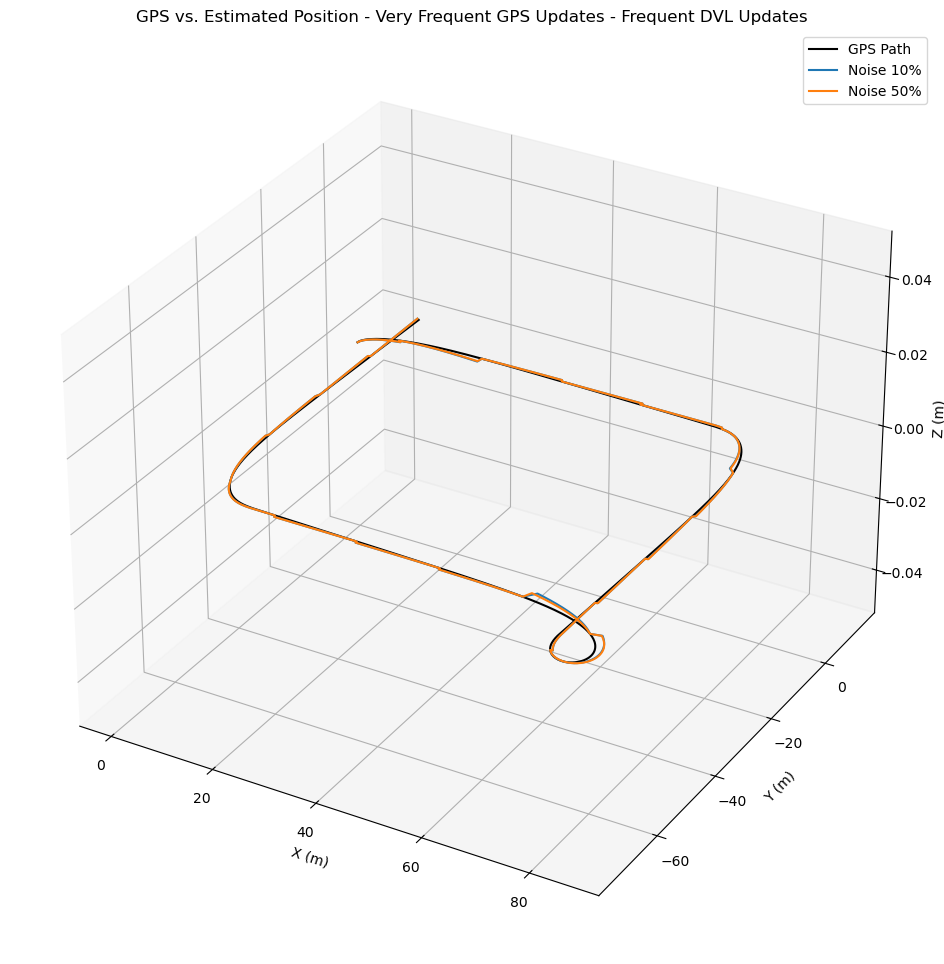

  Noise (% amplitude of Acceleration)   Average RMSE: Distance from path (m)  \
0                                 10%                                   0.57   
1                                 50%                                   0.52   

   Average RMSE: Normalized per distance traveled (%)  
0                                               0.18   
1                                               0.17   


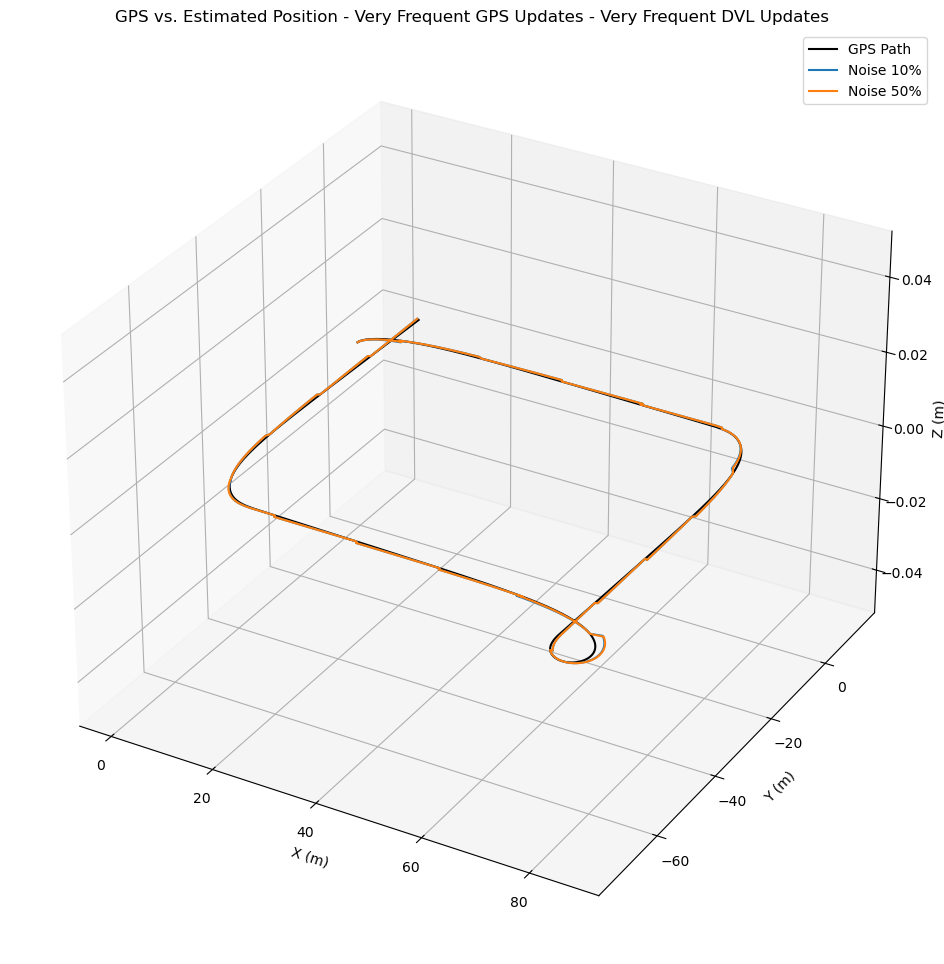

  Noise (% amplitude of Acceleration)   Average RMSE: Distance from path (m)  \
0                                 10%                                   0.45   
1                                 50%                                   0.46   

   Average RMSE: Normalized per distance traveled (%)  
0                                               0.15   
1                                               0.15   


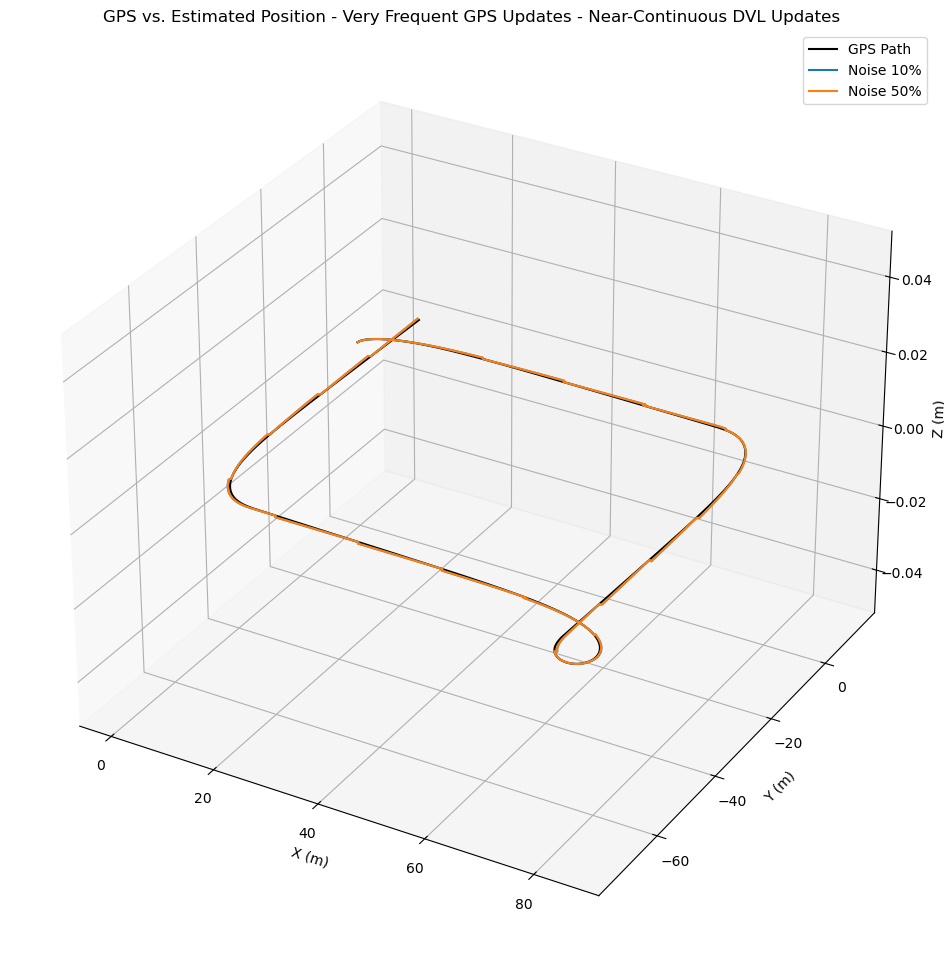

  Noise (% amplitude of Acceleration)   Average RMSE: Distance from path (m)  \
0                                 10%                                   0.31   
1                                 50%                                   0.31   

   Average RMSE: Normalized per distance traveled (%)  
0                                                0.1   
1                                                0.1   


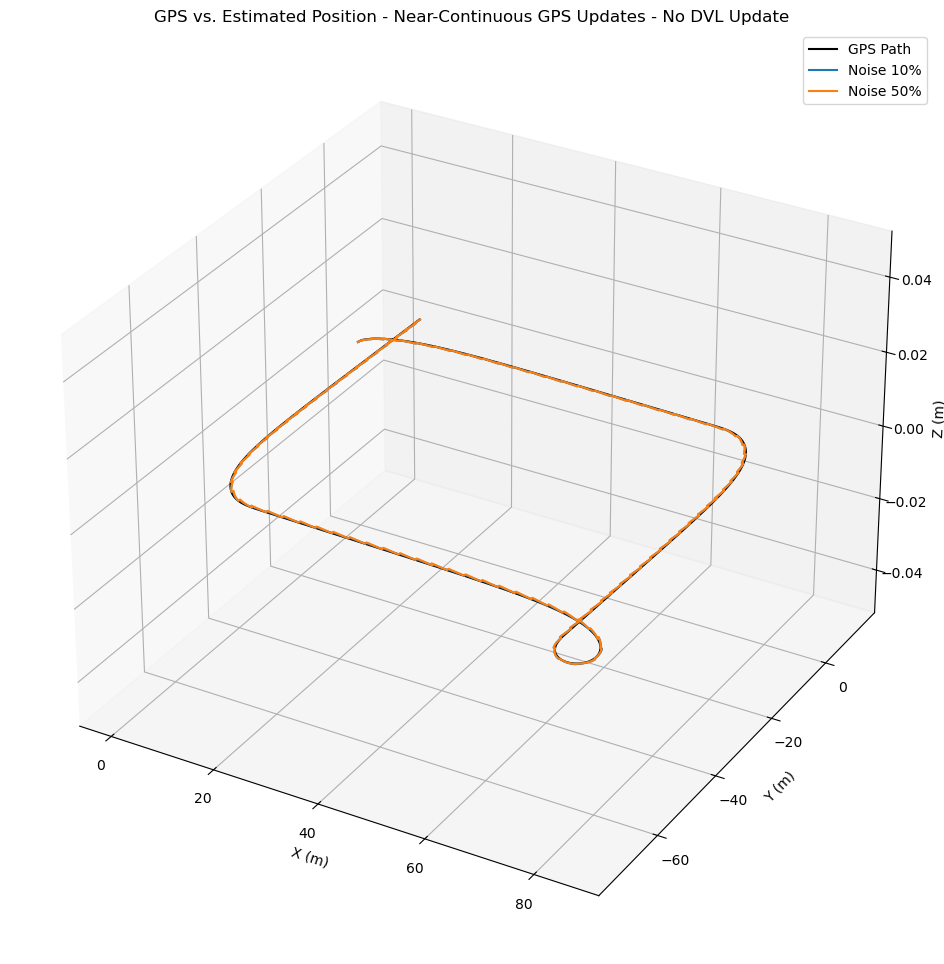

  Noise (% amplitude of Acceleration)   Average RMSE: Distance from path (m)  \
0                                 10%                                   0.21   
1                                 50%                                   0.27   

   Average RMSE: Normalized per distance traveled (%)  
0                                               0.07   
1                                               0.09   


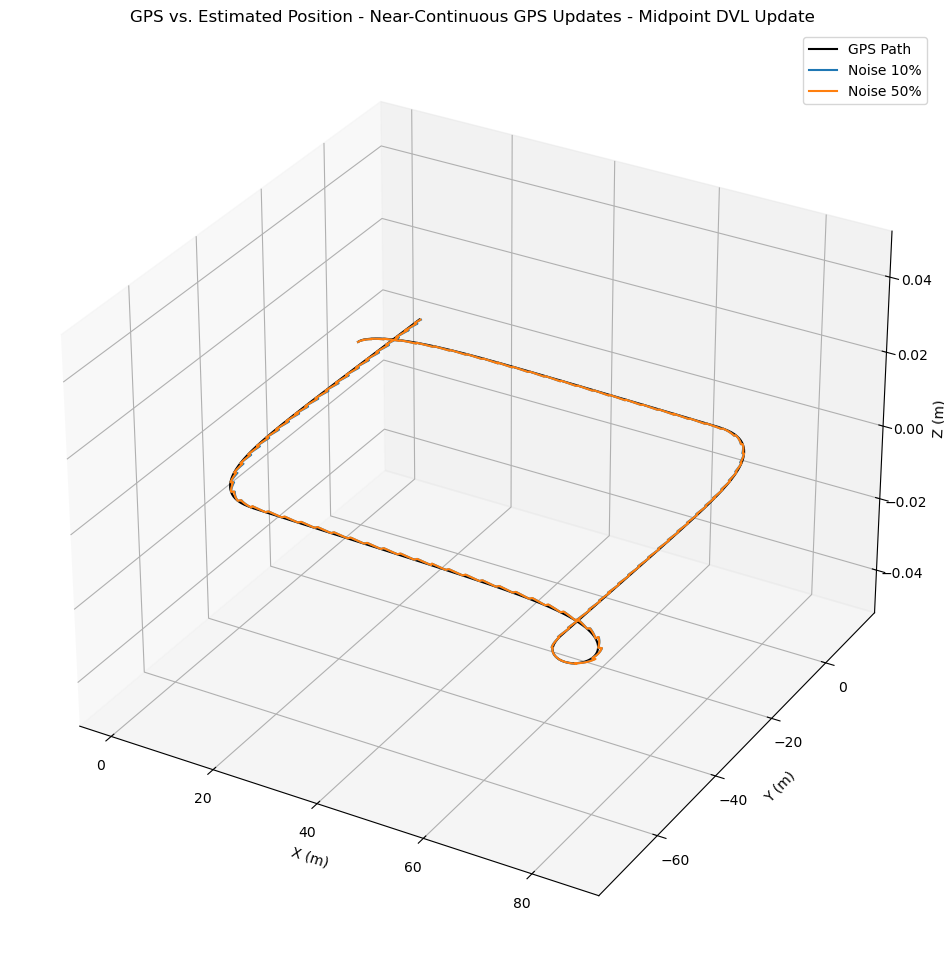

  Noise (% amplitude of Acceleration)   Average RMSE: Distance from path (m)  \
0                                 10%                                   0.30   
1                                 50%                                   0.26   

   Average RMSE: Normalized per distance traveled (%)  
0                                               0.10   
1                                               0.08   


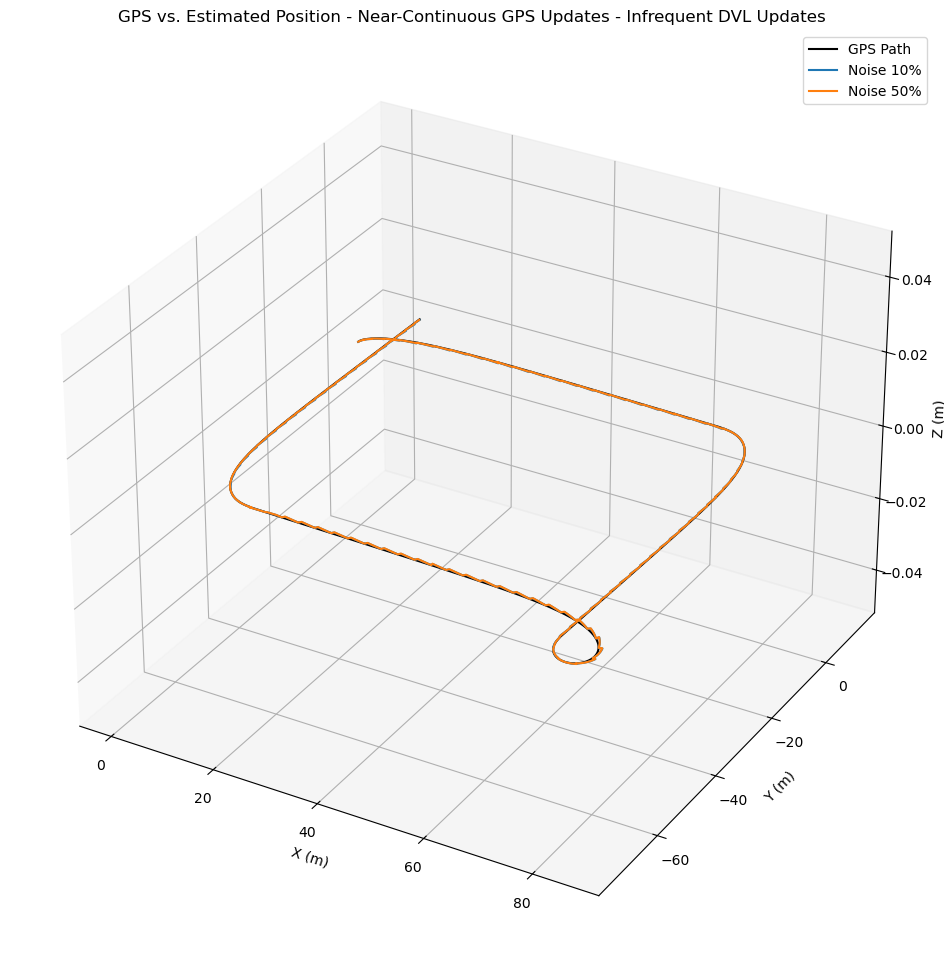

  Noise (% amplitude of Acceleration)   Average RMSE: Distance from path (m)  \
0                                 10%                                   0.28   
1                                 50%                                   0.28   

   Average RMSE: Normalized per distance traveled (%)  
0                                               0.09   
1                                               0.09   


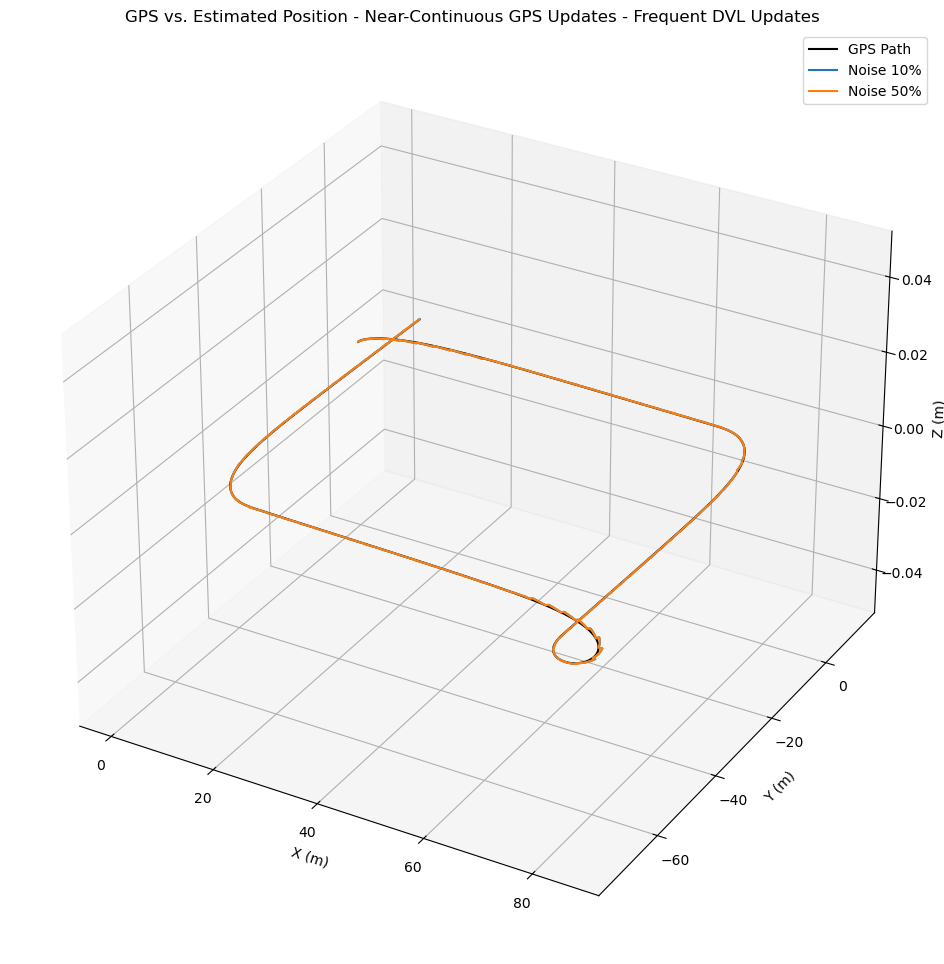

  Noise (% amplitude of Acceleration)   Average RMSE: Distance from path (m)  \
0                                 10%                                    0.2   
1                                 50%                                    0.2   

   Average RMSE: Normalized per distance traveled (%)  
0                                               0.07   
1                                               0.06   


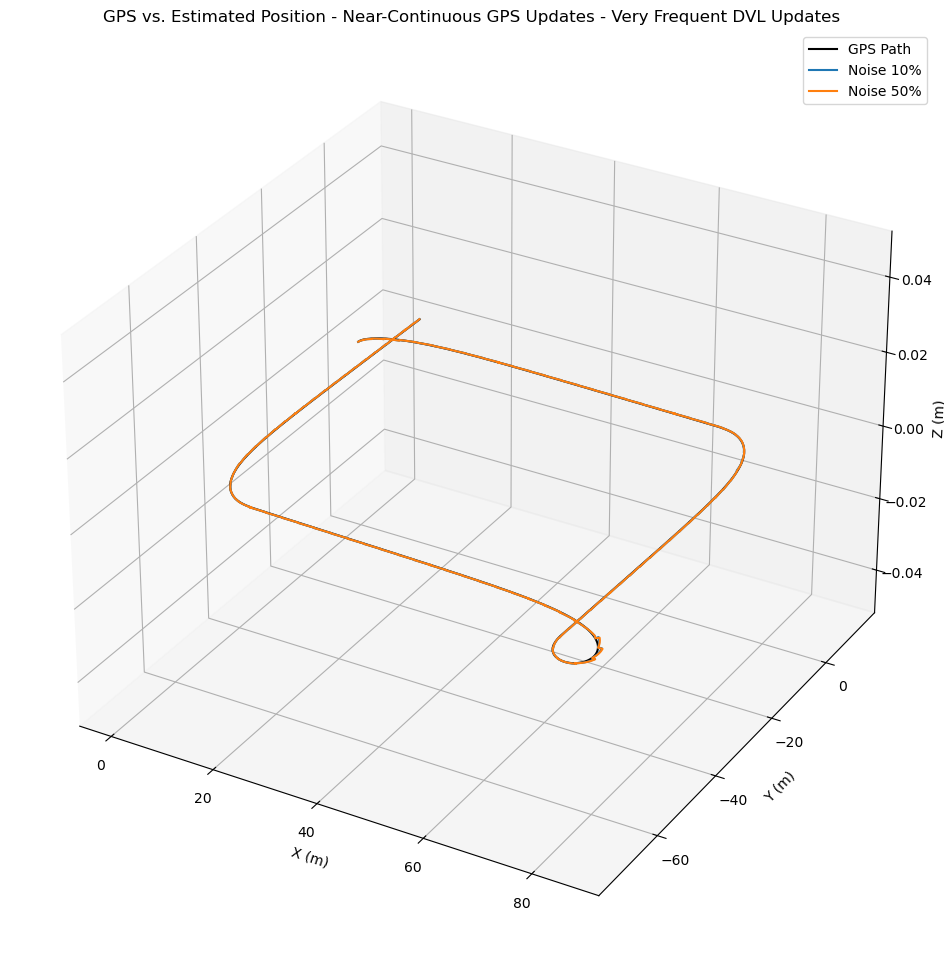

  Noise (% amplitude of Acceleration)   Average RMSE: Distance from path (m)  \
0                                 10%                                   0.19   
1                                 50%                                   0.19   

   Average RMSE: Normalized per distance traveled (%)  
0                                               0.06   
1                                               0.06   


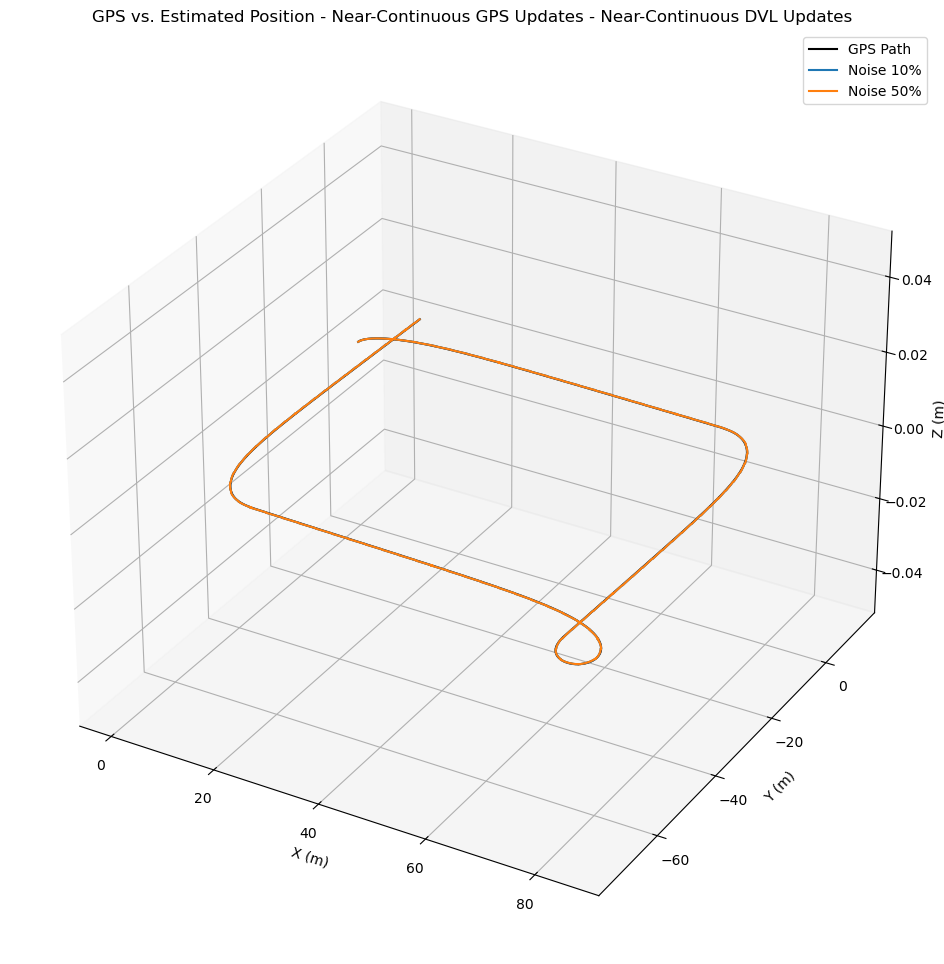

  Noise (% amplitude of Acceleration)   Average RMSE: Distance from path (m)  \
0                                 10%                                   0.17   
1                                 50%                                   0.17   

   Average RMSE: Normalized per distance traveled (%)  
0                                               0.05   
1                                               0.05   


In [163]:
f_dvl_values = [100,50,25,10,5,1]
noise_percentages = [10,50]
f_gps = [100,50,10,5,1]

for f_gps in f_gps_values:
    for f_dvl in f_dvl_values:
        
        imu_positions = {}
        rmse_results = pd.DataFrame(columns=["Noise (% amplitude of Acceleration)", " Average RMSE: Distance from path (m)", "Average RMSE: Normalized per distance traveled (%)"])
        
        for noise_percentage in noise_percentages:
            # Calculate noise amplitude as a percentage of the acceleration value
            noise_amplitude_x = noise_percentage / 100 * accel_data['accel_x (m/s^2)']
            noise_amplitude_y = noise_percentage / 100 * accel_data['accel_y (m/s^2)']
            noise_amplitude_z = noise_percentage / 100 * accel_data['accel_z (m/s^2)']
        
            # Generate random noise within the range and add it to the acceleration data
            noisy_accel_x = accel_data['accel_x (m/s^2)'] + np.random.uniform(-noise_amplitude_x, noise_amplitude_x)
            noisy_accel_y = accel_data['accel_y (m/s^2)'] + np.random.uniform(-noise_amplitude_y, noise_amplitude_y)
            noisy_accel_z = accel_data['accel_z (m/s^2)'] + np.random.uniform(-noise_amplitude_z, noise_amplitude_z)
        
            # Combine noisy acceleration into a single numpy array
            noisy_accel = np.column_stack((noisy_accel_x, noisy_accel_y, noisy_accel_z))
        
            # Run Kalman filter and transform acceleration to NED frame
            filtered_accel_ned = run_kalman_filter_with_transformation(noisy_accel, mag_data, delta_t, var=noise_level**2)
        
            # Calculate positions with GPS update
            imu_positions_x, imu_positions_y = calculate_position_with_gps_update(filtered_accel_ned, gps_data, time_data['time (sec)'], delta_t, f_gps, f_dvl)
        
            #Calculate RMSE
            rmse, normalized_rmse = calculate_rmse(imu_positions_x, imu_positions_y, time_data['time (sec)'], gps_data, gps_time_data['gps_time (sec)'])
            
            imu_positions[f"Noise {noise_percentage}%"] = (imu_positions_x, imu_positions_y)
        
            rmse_results.loc[len(rmse_results)] = [f"{noise_percentage}%", rmse, normalized_rmse]
        
        # Plot all data
        plot_data(imu_positions, gps_data, [f"Noise {n}% Acceleration Amplitude" for n in noise_percentages], f_gps, f_dvl)
        print(rmse_results)

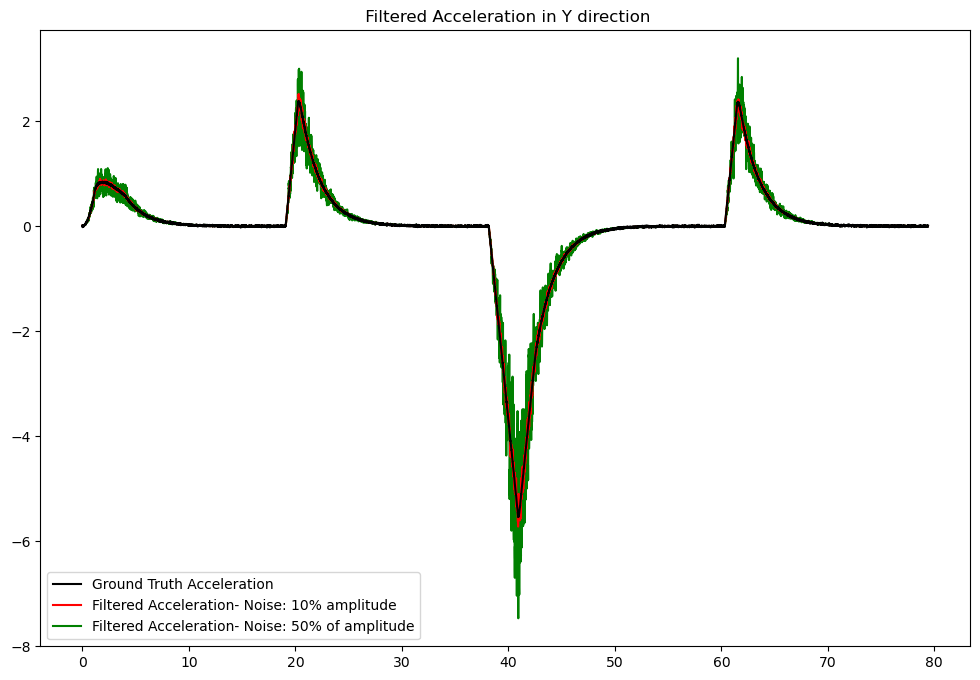

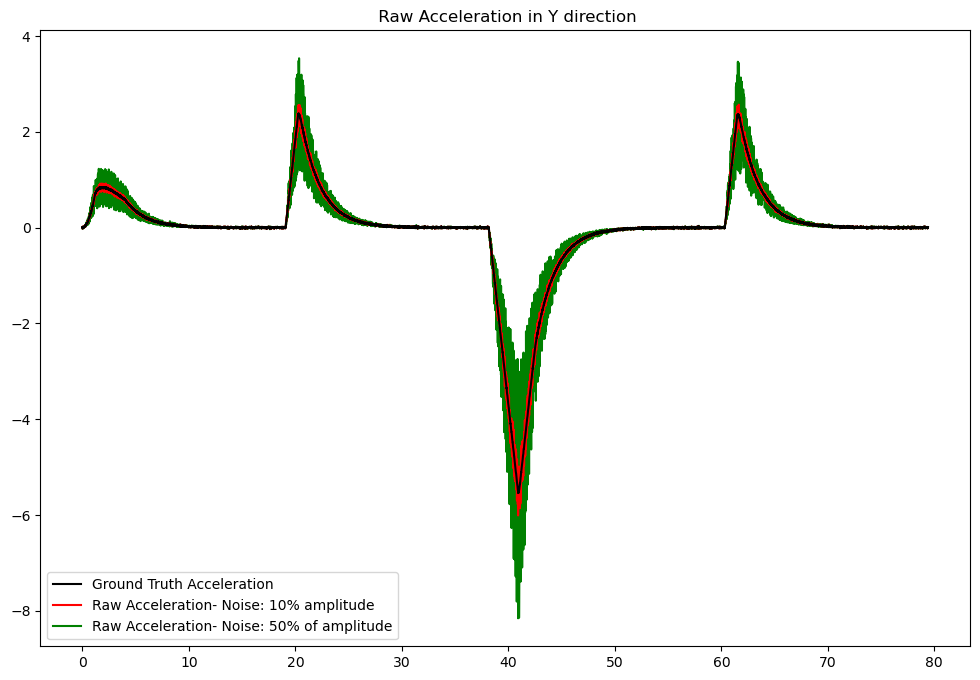

In [172]:
time = time_data['time (sec)'].to_numpy()
noise_percentage = 10
# Calculate noise amplitude as a percentage of the acceleration value
noise_amplitude_x = noise_percentage / 100 * accel_data['accel_x (m/s^2)']
noise_amplitude_y = noise_percentage / 100 * accel_data['accel_y (m/s^2)']
noise_amplitude_z = noise_percentage / 100 * accel_data['accel_z (m/s^2)']

# Generate random noise within the range and add it to the acceleration data
noisy_accel_x = accel_data['accel_x (m/s^2)'] + np.random.uniform(-noise_amplitude_x, noise_amplitude_x)
noisy_accel_y_1 = accel_data['accel_y (m/s^2)'] + np.random.uniform(-noise_amplitude_y, noise_amplitude_y)
noisy_accel_z = accel_data['accel_z (m/s^2)'] + np.random.uniform(-noise_amplitude_z, noise_amplitude_z)

noisy_accel = np.column_stack((noisy_accel_x, noisy_accel_y_1, noisy_accel_z))


filtered_accel_1 = run_kalman_filter(noisy_accel[:, 1], delta_t, var=noise_level**2)

noise_percentage = 50
# Calculate noise amplitude as a percentage of the acceleration value
noise_amplitude_x = noise_percentage / 100 * accel_data['accel_x (m/s^2)']
noise_amplitude_y = noise_percentage / 100 * accel_data['accel_y (m/s^2)']
noise_amplitude_z = noise_percentage / 100 * accel_data['accel_z (m/s^2)']

# Generate random noise within the range and add it to the acceleration data
noisy_accel_x = accel_data['accel_x (m/s^2)'] + np.random.uniform(-noise_amplitude_x, noise_amplitude_x)
noisy_accel_y_2 = accel_data['accel_y (m/s^2)'] + np.random.uniform(-noise_amplitude_y, noise_amplitude_y)
noisy_accel_z = accel_data['accel_z (m/s^2)'] + np.random.uniform(-noise_amplitude_z, noise_amplitude_z)

noisy_accel = np.column_stack((noisy_accel_x, noisy_accel_y_2, noisy_accel_z))

# Run Kalman filter and transform acceleration to NED frame
filtered_accel_2 = run_kalman_filter(noisy_accel[:, 1], delta_t, var=noise_level**2)


plt.figure(figsize=(12, 8))
plt.plot(time, accel_data['accel_y (m/s^2)'], label='Ground Truth Acceleration',  color='black', zorder=3)
plt.plot(time, filtered_accel_1, label='Filtered Acceleration- Noise: 10% amplitude',  color='red', zorder=2)
plt.plot(time, filtered_accel_2, label='Filtered Acceleration- Noise: 50% of amplitude',  color='green', zorder=1)
plt.title(' Filtered Acceleration in Y direction')
plt.legend()

plt.figure(figsize=(12, 8))
plt.plot(time, accel_data['accel_y (m/s^2)'], label='Ground Truth Acceleration',  color='black', zorder=3)
plt.plot(time, noisy_accel_y_1, label='Raw Acceleration- Noise: 10% amplitude',  color='red', zorder=2)
plt.plot(time, noisy_accel_y_2, label='Raw Acceleration- Noise: 50% of amplitude',  color='green', zorder=1)
plt.title(' Raw Acceleration in Y direction')
plt.legend()

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(time, accel_data['accel_y (m/s^2)'], label='Ground Truth Acceleration',  color='black', zorder=3)
plt.plot(time, noisy, label='Filtered Acceleration- Noise: 10% amplitude',  color='red', zorder=2)
plt.plot(time, filtered_accel_2, label='Filtered Acceleration- Noise: 50% of amplitude',  color='green', zorder=1)
plt.title(' Filtered Acceleration in Y direction')
plt.legend()